# Quantile Regression Benchmarks

env: quantile_benchmark

created on March 23, 2025 by Yi-Ping and Co-pilot

## Evidential Regression

In [16]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# re-create toy y = x ** 3 + eps example from https://arxiv.org/abs/1910.02600

torch.manual_seed(0)

x_train = torch.linspace(-5, 4, 2000).unsqueeze(-1)
mask = (x_train < -4) | (x_train > -1)
x_train = x_train[mask].unsqueeze(-1)

sigma = torch.distributions.exponential.Exponential(1.0).sample(x_train.shape) * 15 - 15
y_train = x_train**3 + sigma

x_test = torch.linspace(-7, 7, 1000).unsqueeze(-1)
y_test = x_test**3
y_test_noisy = x_test**3 + torch.distributions.exponential.Exponential(1.0).sample(x_test.shape) * 15 - 15
y_test_noisy = y_test_noisy.numpy().squeeze()

# Move data to the device
x_train, y_train = x_train.to(device), y_train.to(device)

In [17]:
from edl_pytorch import NormalInvGamma, evidential_regression

# Move the model to the device
evd_model = nn.Sequential(
    nn.Linear(1, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    NormalInvGamma(64, 1),
).to(device)

optimizer = torch.optim.Adam(evd_model.parameters(), lr=1e-4)



for _ in tqdm(range(500)):
    for x, y in DataLoader(TensorDataset(x_train, y_train), batch_size=100, shuffle=True):
        x, y = x.to(device), y.to(device)  # Ensure batch data is on the device
        pred = evd_model(x)
        loss = evidential_regression(pred, y, lamb=1e-4)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

evd_model.cpu()
with torch.no_grad():
    pred = evd_model(x_test)

mu, v, alpha, beta = (d.squeeze() for d in pred)
X_test = x_test.squeeze()
var = torch.sqrt(beta / (v * (alpha - 1)))


100%|██████████| 500/500 [00:14<00:00, 35.38it/s]


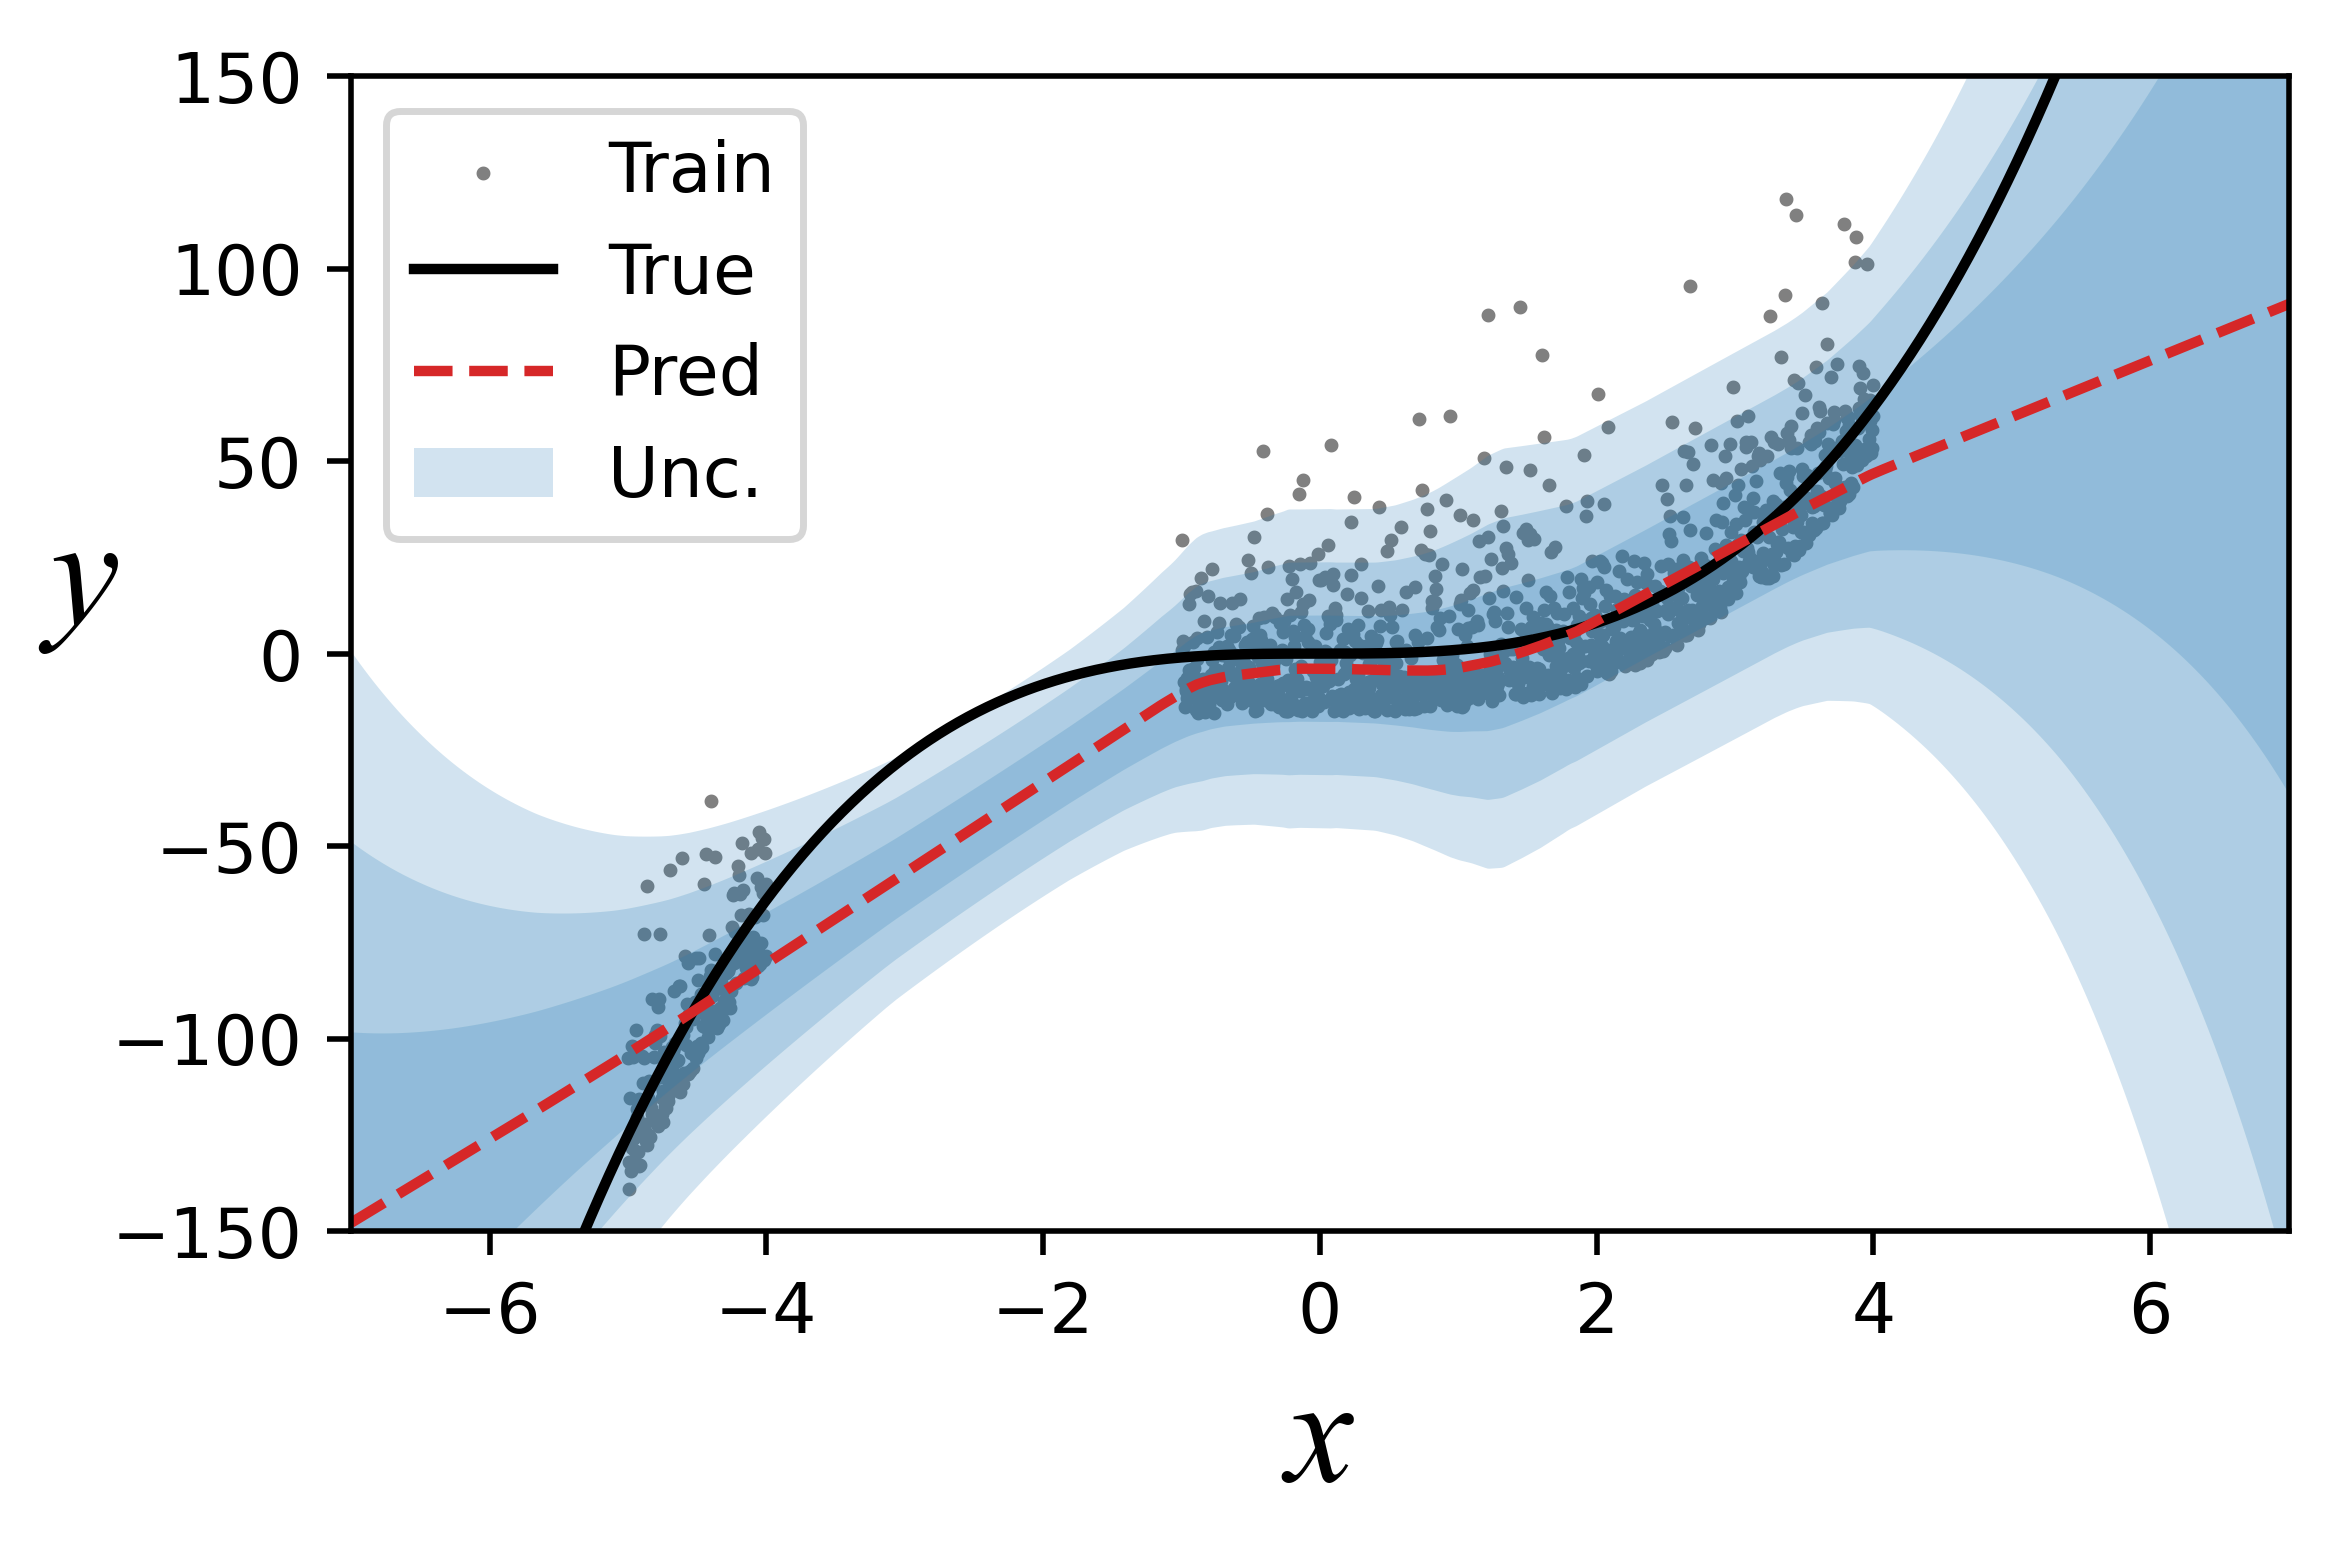

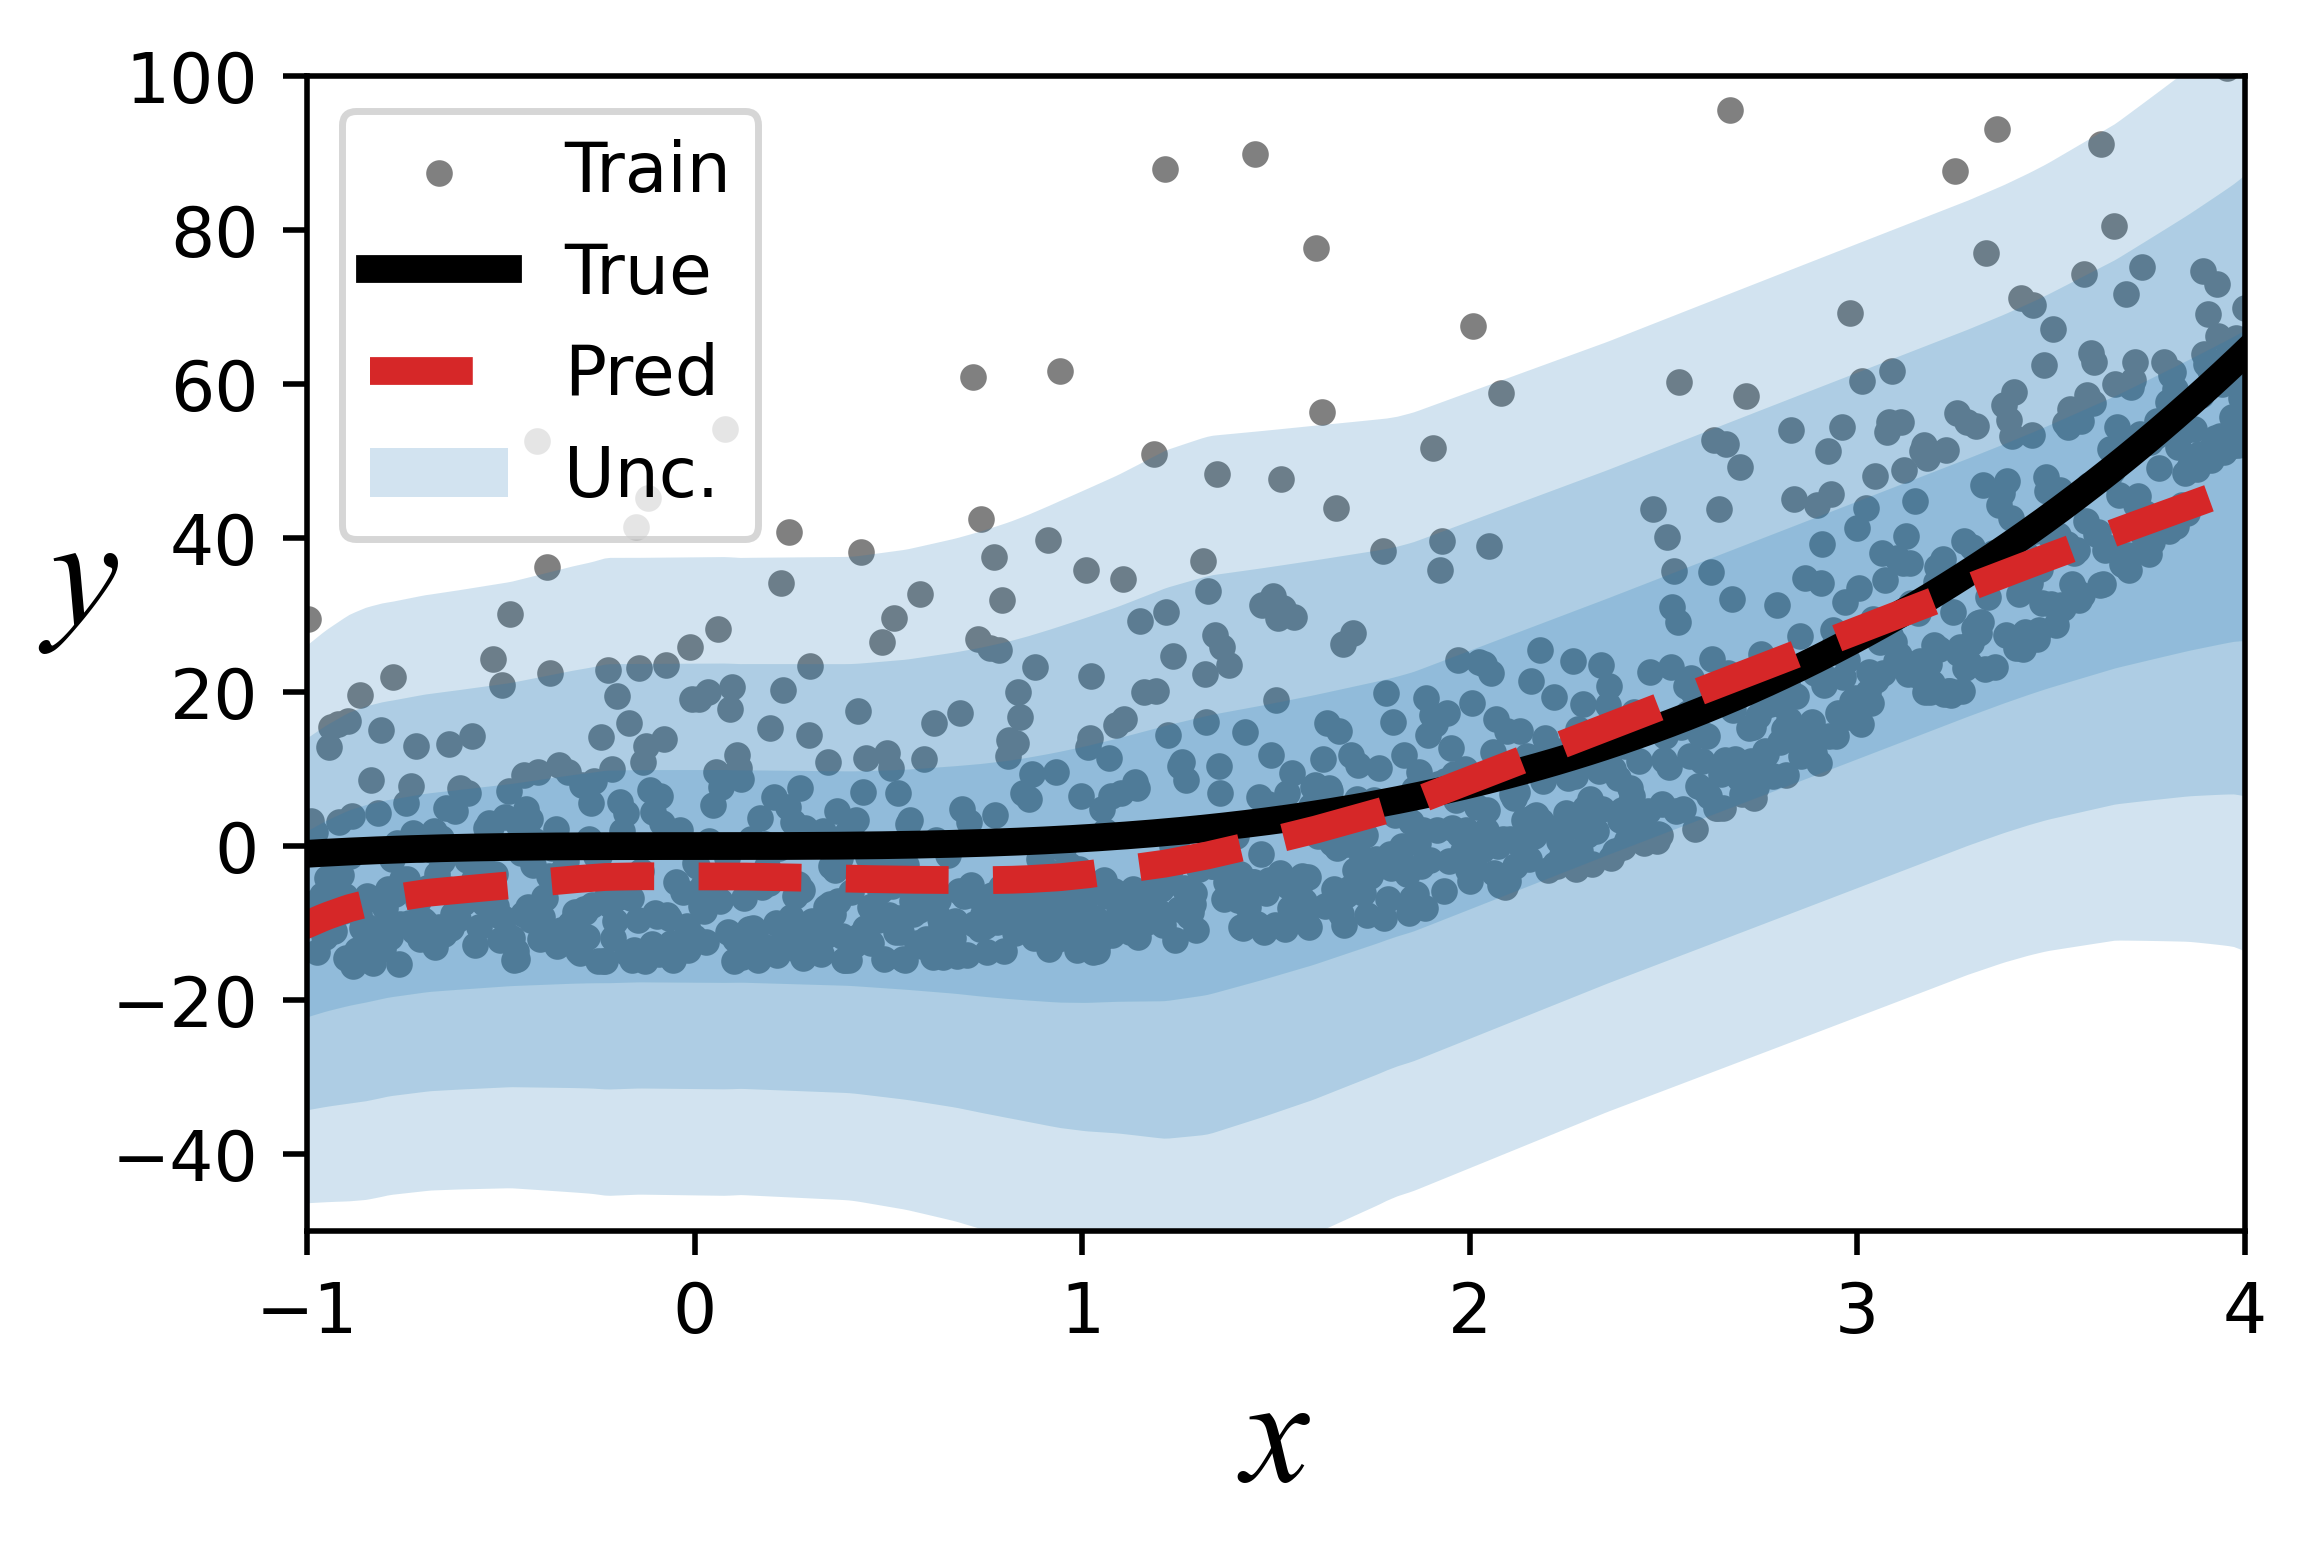

In [18]:
# plot code modified from
# https://github.com/aamini/evidential-deep-learning/blob/main/hello_world.py#L48
plt.figure(figsize=(5, 3), dpi=500)
plt.scatter(x_train.cpu(), y_train.cpu(), s=1.0, facecolor="gray", label="Train", alpha=1, edgecolors=None)
plt.plot(X_test, y_test, c="k", label="True")
plt.plot(X_test, mu, c="tab:red", ls="--", label="Pred")
for std in range(4):
    plt.fill_between(
        X_test,
        (mu - std * var),
        (mu + std * var),
        alpha=0.2,
        facecolor="tab:blue",
        label="Unc." if std == 0 else None,
    )
plt.gca().set_ylim(-150, 150)
plt.gca().set_xlim(-7, 7)
plt.xlabel("x", fontsize=22, fontdict={
    'family': 'Times New Roman',
    'style': 'italic'
})

plt.ylabel("y", fontsize=22, fontdict={
    'family': 'Times New Roman',
    'style': 'italic'
},rotation=0)
plt.legend(loc="upper left")

# ===================================

plt.figure(figsize=(5, 3), dpi=500)
plt.scatter(x_train.cpu(), y_train.cpu(), s=8.0, facecolor="gray", label="Train", alpha=1, edgecolors=None)
plt.plot(X_test, y_test, c="k", label="True", linewidth=4)
plt.plot(X_test, mu, c="tab:red", ls="--", label="Pred", linewidth=4)
for std in range(4):
    plt.fill_between(
        X_test,
        (mu - std * var),
        (mu + std * var),
        alpha=0.2,
        facecolor="tab:blue",
        label="Unc." if std == 0 else None,
    )
plt.gca().set_ylim(-50, 100)
plt.gca().set_xlim(-1, 4)

plt.xlabel("x", fontsize=22, fontdict={
    'family': 'Times New Roman',
    'style': 'italic'
})

plt.ylabel("y", fontsize=22, fontdict={
    'family': 'Times New Roman',
    'style': 'italic'
},rotation=0)
plt.legend(loc="upper left")



In [ ]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Assumes these are torch tensors on CPU:
# mu, var, y_test, x_train, y_train

# If needed, convert to numpy
mu_np = mu.detach().cpu().numpy()
var_np = var.detach().cpu().numpy()
y_test_np = y_test.detach().cpu().numpy()

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test_np, mu_np))
print(f"RMSE: {rmse:.4f}")

# Compute R² score
r2 = r2_score(y_test_np, mu_np)
print(f"R^2: {r2:.4f}")


# If we match each (x_train, y_train) to the nearest X_test point:
X_test_np = X_test if isinstance(X_test, np.ndarray) else X_test.detach().cpu().numpy()


# Check how many training targets fall within n std of predicted mean
coverage = {}
for n in range(1, 4):
    lower = mu_np - n * var_np
    upper = mu_np + n * var_np
    covered = (y_test_noisy >= lower) & (y_test_noisy <= upper)
    frac_covered = np.sum(covered) / len(y_test_noisy)
    coverage[n] = frac_covered
    print(f"Coverage within ±{n}σ: {frac_covered:.2%}")


RMSE: 73.8495
R^2: 0.6774
Coverage within ±1σ: 40.20%
Coverage within ±2σ: 68.40%
Coverage within ±3σ: 85.80%


In [73]:
lower.shape

(1000,)

## Gaussian Process

In [77]:
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood, FixedNoiseGaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import NormalPrior

# Define the GP model with a learned nugget
class GPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())
        self.likelihood.noise_covar.register_constraint("raw_noise", gpytorch.constraints.Positive())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Prepare data for GP
x_train_gp = x_train.squeeze()
y_train_gp = y_train.squeeze()


prior = NormalPrior(torch.zeros(1), torch.ones(1)*15**2)
likelihood = GaussianLikelihood(noise_prior=prior)  #GaussianLikelihood()
gp_model = GPModel(x_train_gp, y_train_gp, likelihood).to(device)

# Train the GP model
gp_model.train()
likelihood.train()

optimizer = torch.optim.Adam(gp_model.parameters(), lr=0.1)
mll = ExactMarginalLogLikelihood(likelihood, gp_model)

for _ in range(50):  # Training for 50 iterations
    optimizer.zero_grad()
    output = gp_model(x_train_gp)
    loss = -mll(output, y_train_gp)
    loss.backward()
    optimizer.step()

# Switch to evaluation mode
gp_model.eval().cpu()
likelihood.eval().cpu()


# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(gp_model(x_test.squeeze()))
    mu = observed_pred.mean
    var = observed_pred.variance.sqrt()
    X_test = x_test.squeeze()


Learned noise: 3.21736478805542


(-1.0, 4.0)

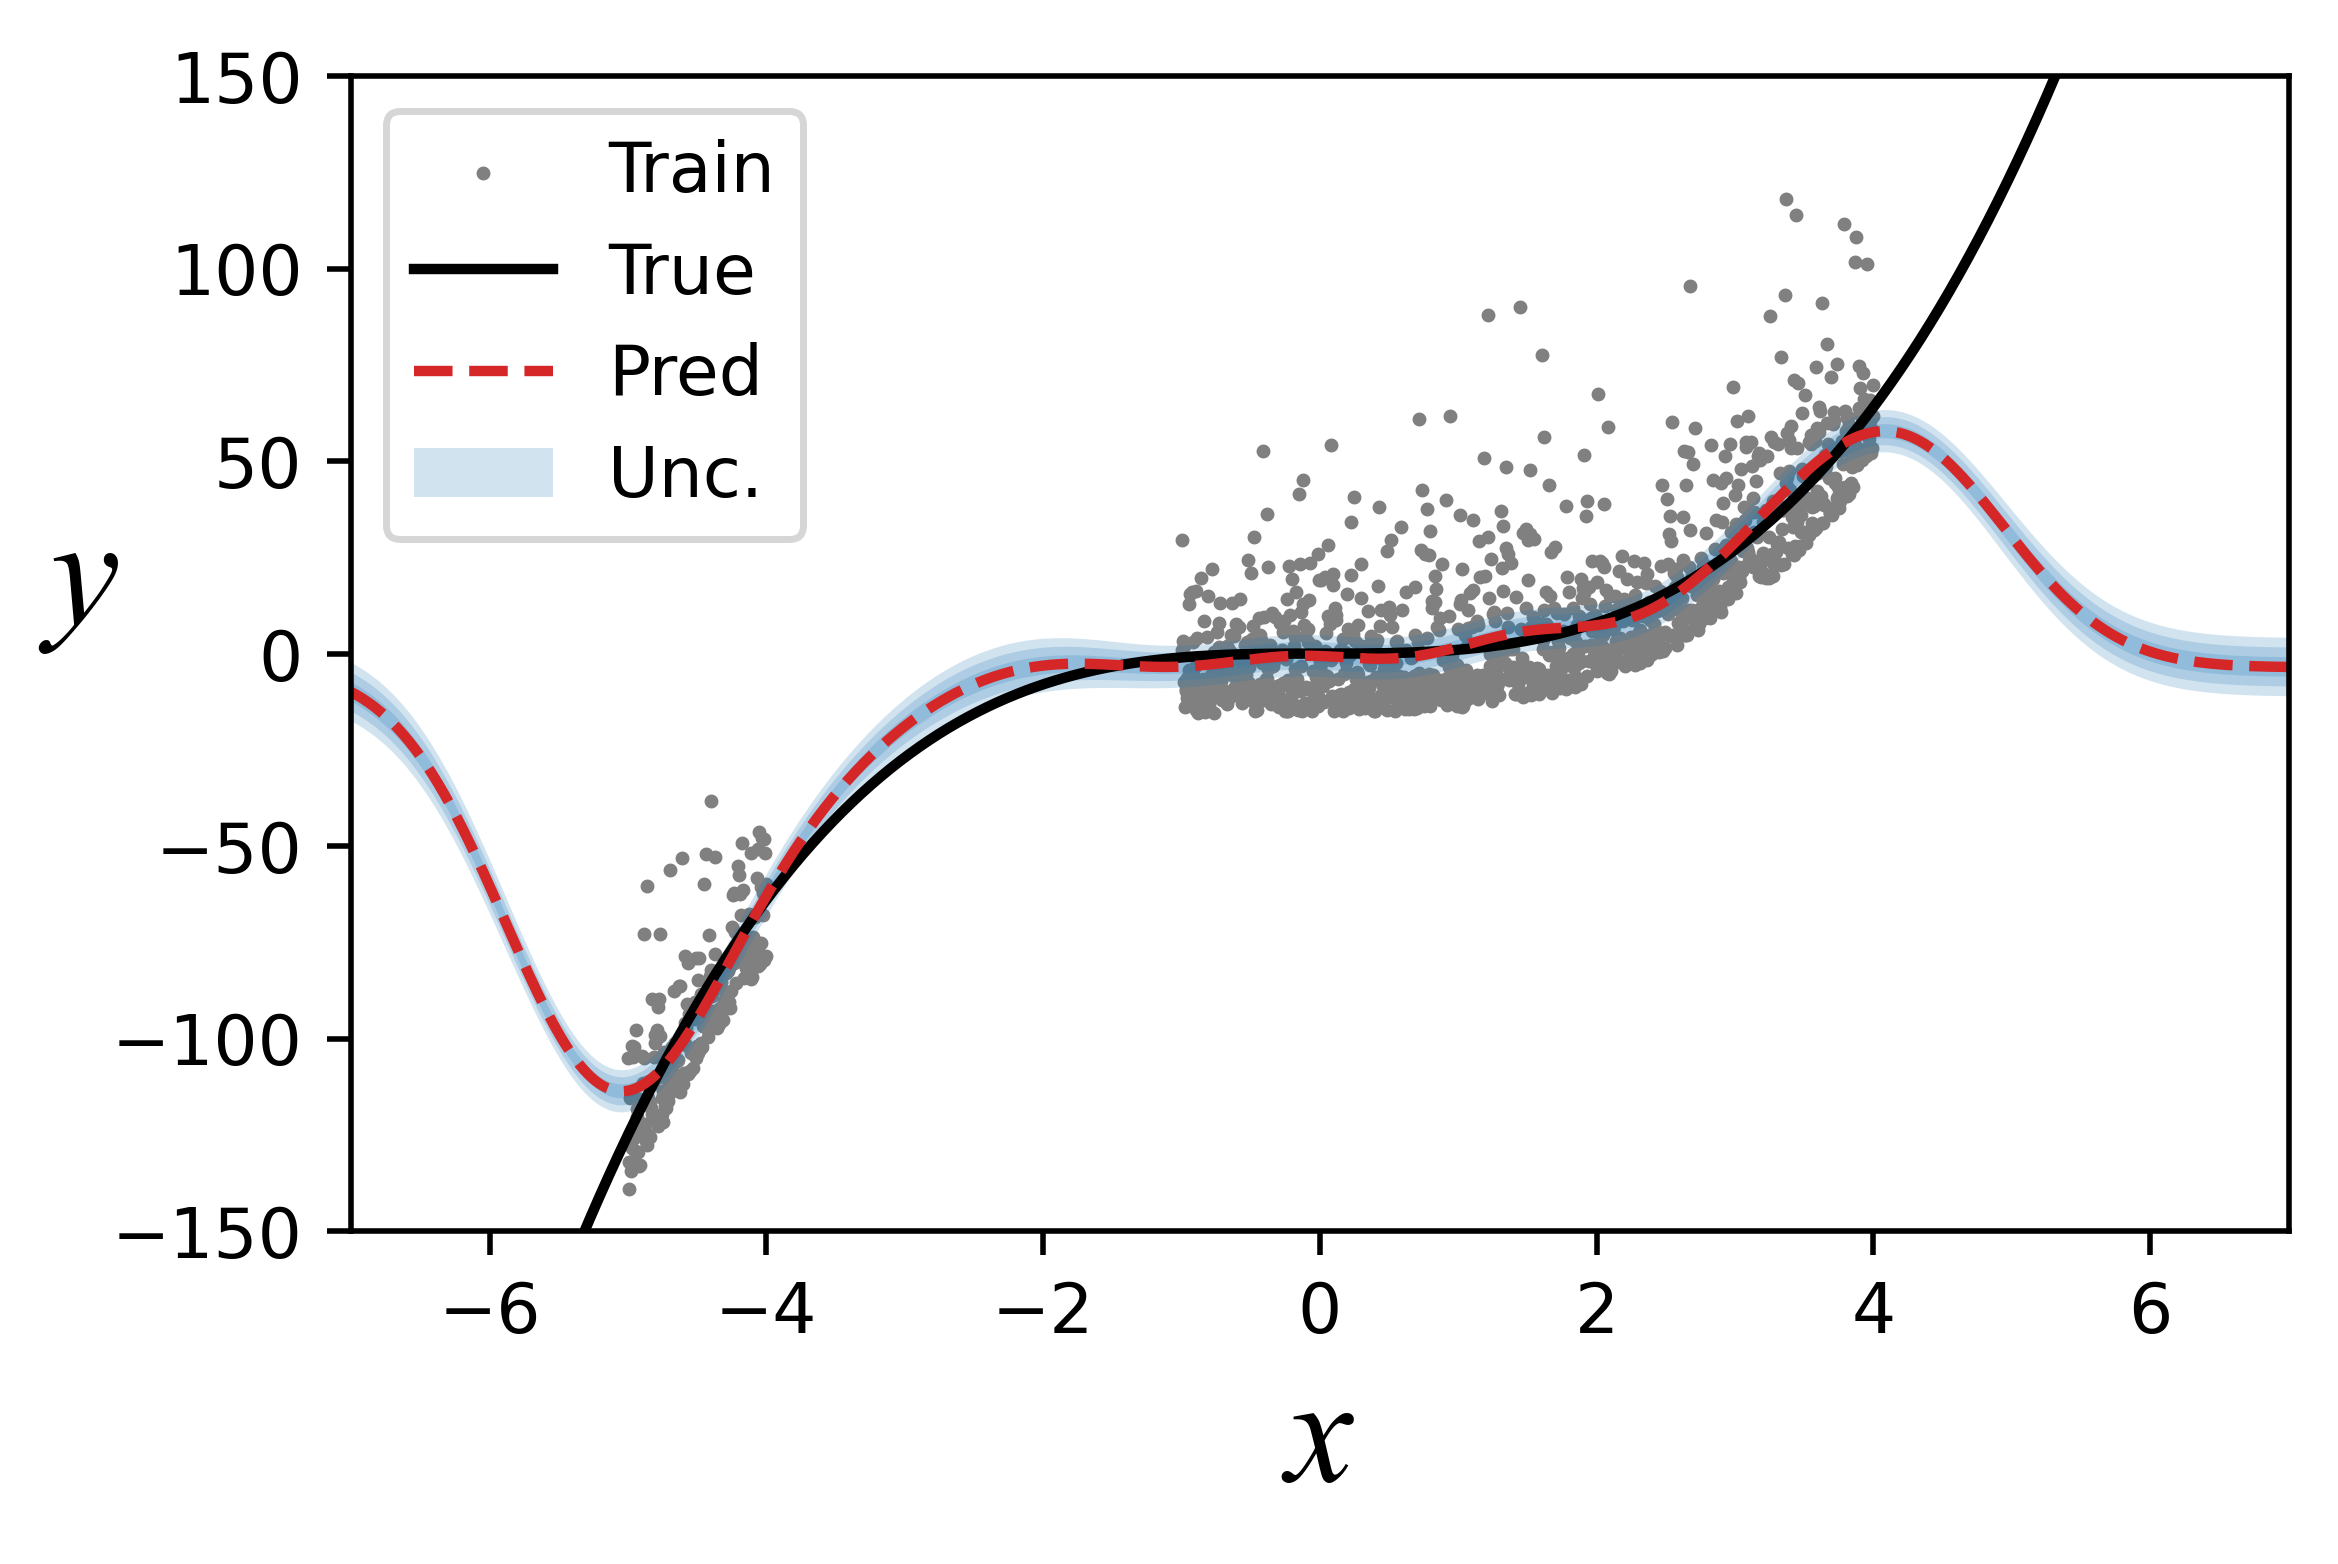

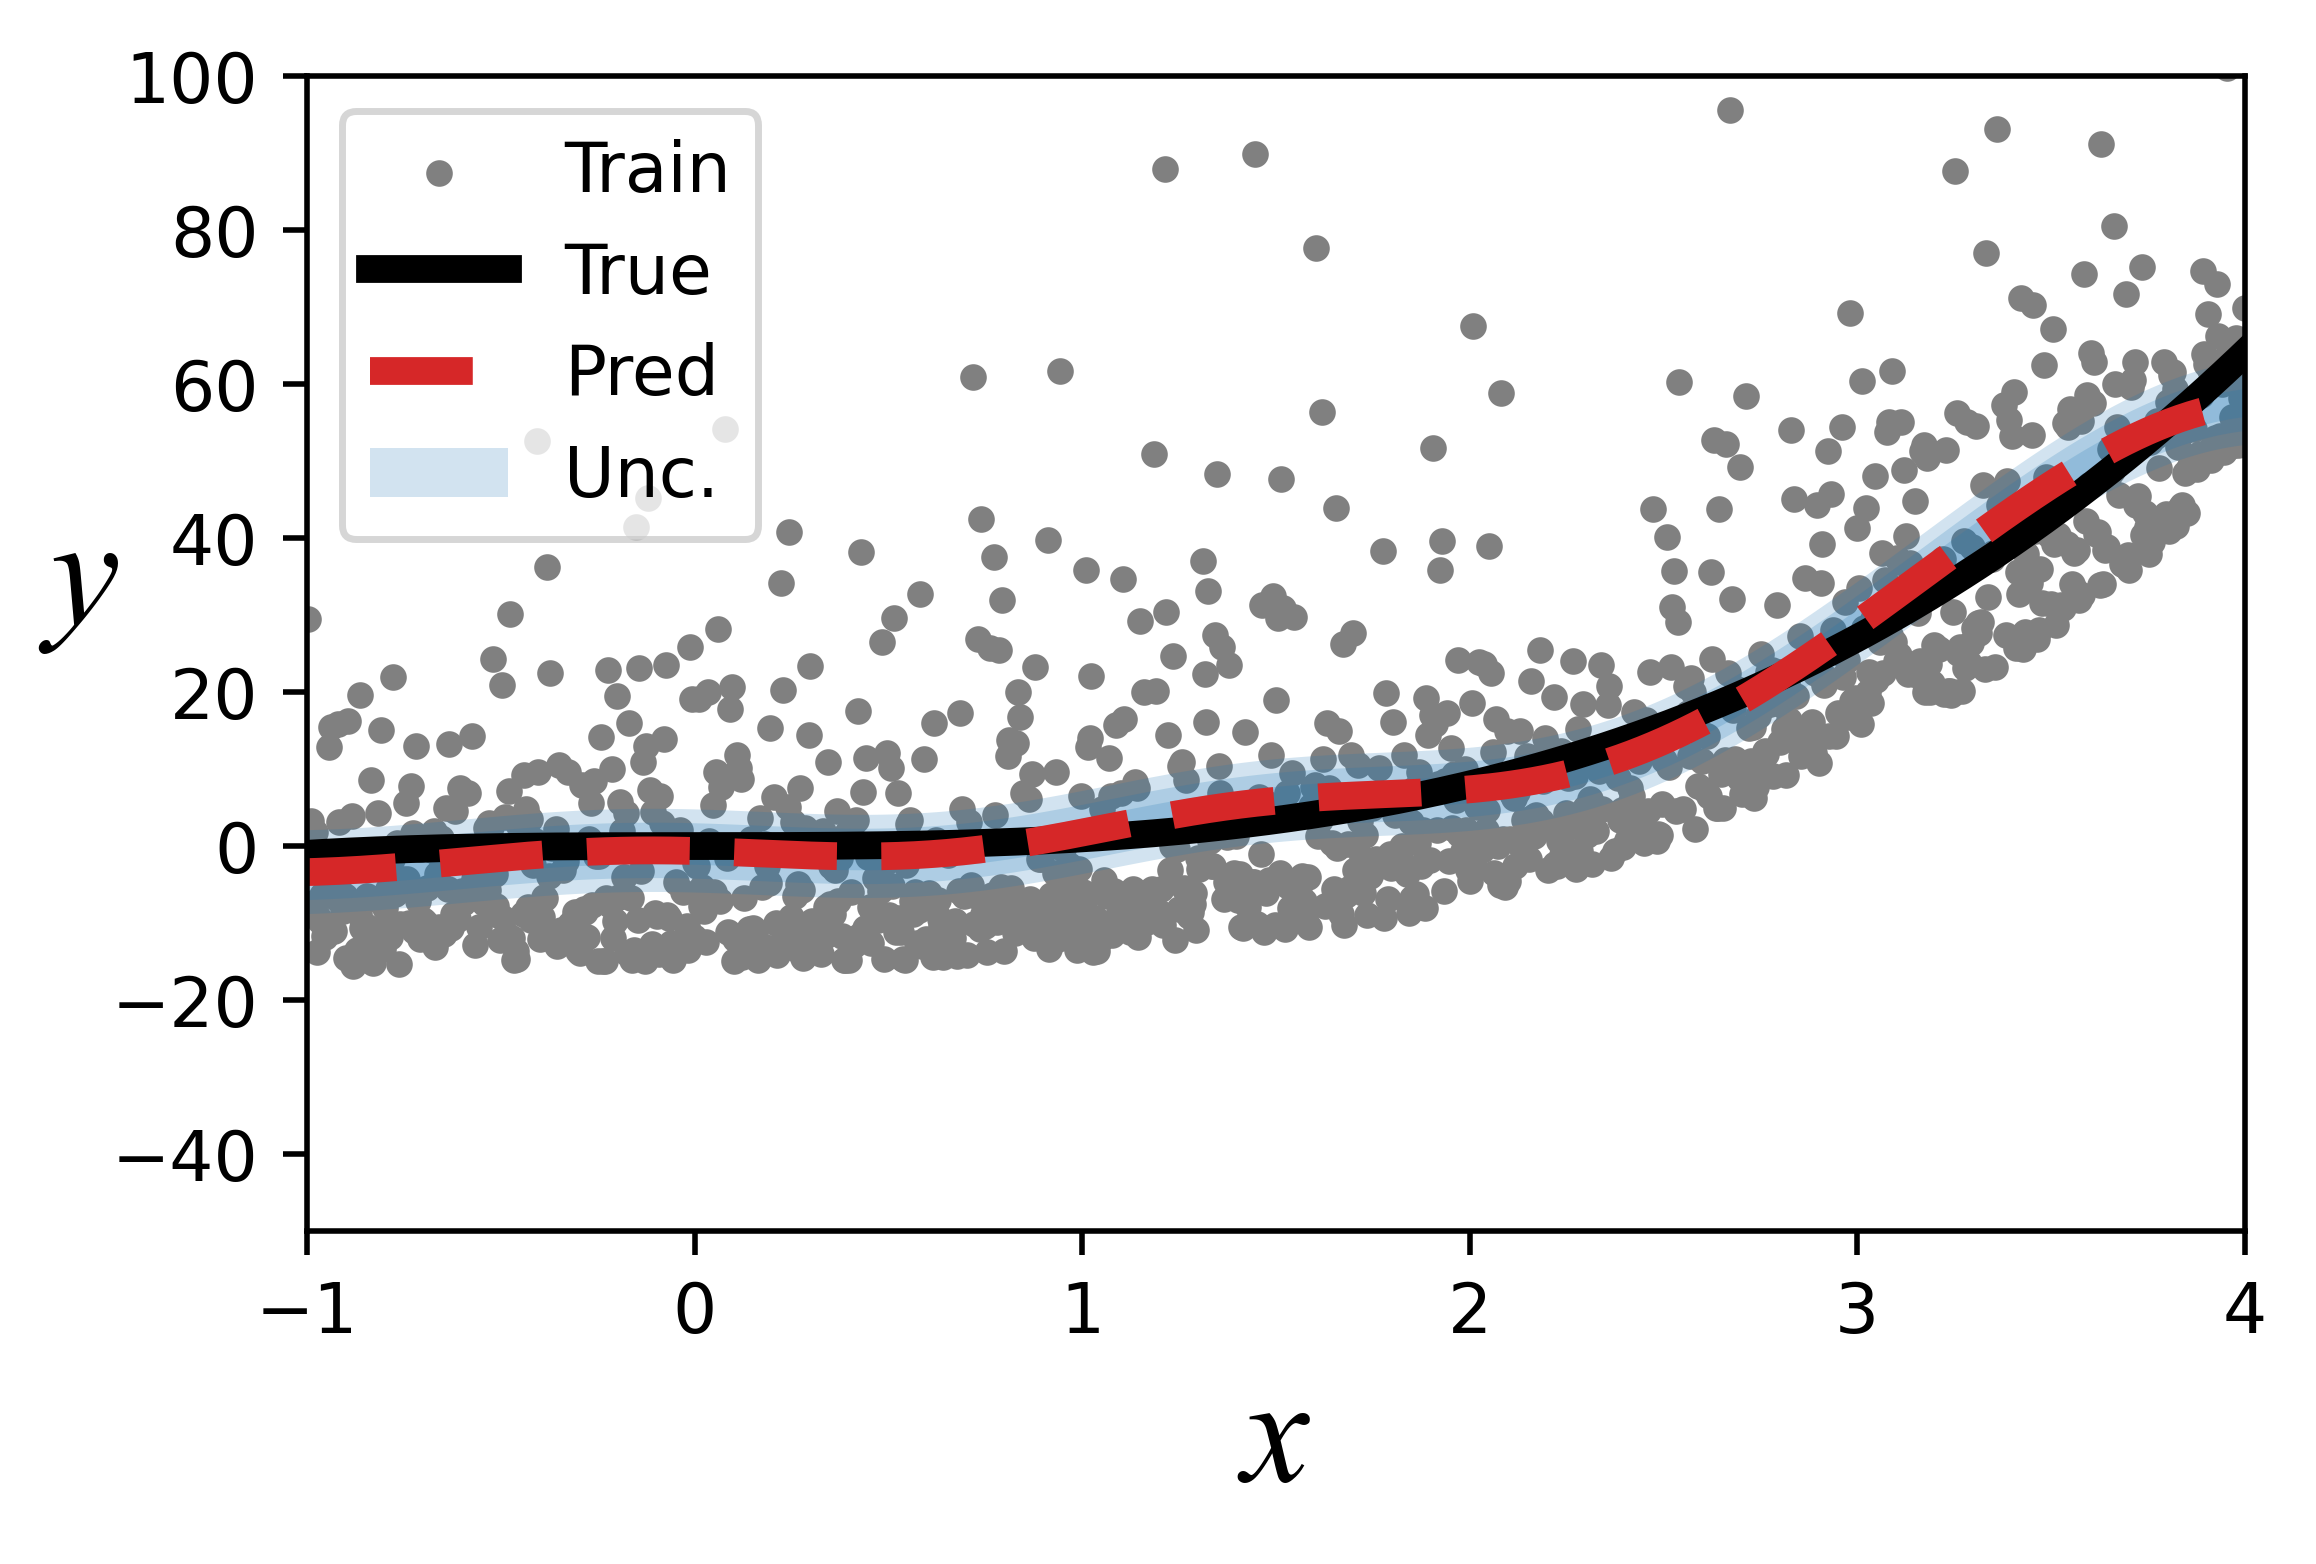

In [ ]:
print("Learned noise:", likelihood.noise.item())

plt.figure(figsize=(5, 3), dpi=500)
plt.scatter(x_train.cpu(), y_train.cpu(), s=1.0, facecolor="gray", label="Train", alpha=1, edgecolors=None)
plt.plot(X_test, y_test, c="k", label="True")
plt.plot(X_test, mu, c="tab:red", ls="--", label="Pred")
for std in range(4):
    plt.fill_between(
        X_test,
        (mu - std * var),
        (mu + std * var),
        alpha=0.2,
        facecolor="tab:blue",
        label="Unc." if std == 0 else None,
    )
plt.gca().set_ylim(-150, 150)
plt.gca().set_xlim(-7, 7)

plt.xlabel("x", fontsize=22, fontdict={
    'family': 'Times New Roman',
    'style': 'italic'
})

plt.ylabel("y", fontsize=22, fontdict={
    'family': 'Times New Roman',
    'style': 'italic'
},rotation=0)
plt.legend(loc="upper left")

# ================================

plt.figure(figsize=(5, 3), dpi=500)
plt.scatter(x_train.cpu(), y_train.cpu(), s=8.0, facecolor="gray", label="Train", alpha=1, edgecolors=None)
plt.plot(X_test, y_test, c="k", label="True", linewidth=4)
plt.plot(X_test, mu, c="tab:red", ls="--", label="Pred", linewidth=4)
for std in range(4):
    plt.fill_between(
        X_test,
        (mu - std * var),
        (mu + std * var),
        alpha=0.2,
        facecolor="tab:blue",
        label="Unc." if std == 0 else None,
    )
plt.gca().set_ylim(-150, 150)
plt.gca().set_xlim(-7, 7)

plt.xlabel("x", fontsize=22, fontdict={
    'family': 'Times New Roman',
    'style': 'italic'
})

plt.ylabel("y", fontsize=22, fontdict={
    'family': 'Times New Roman',
    'style': 'italic'
},rotation=0)
plt.legend(loc="upper left")
plt.gca().set_ylim(-50, 100)
plt.gca().set_xlim(-1, 4)


In [ ]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Assumes these are torch tensors on CPU:
# mu, var, y_test, x_train, y_train

# If needed, convert to numpy
mu_np = mu.detach().cpu().numpy()
var_np = var.detach().cpu().numpy()
y_test_np = y_test.detach().cpu().numpy()

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test_np, mu_np))
print(f"RMSE: {rmse:.4f}")

# Compute R² score
r2 = r2_score(y_test_np, mu_np)
print(f"R^2: {r2:.4f}")

X_test_np = X_test if isinstance(X_test, np.ndarray) else X_test.detach().cpu().numpy()


# Check how many training targets fall within n std of predicted mean
coverage = {}
for n in range(1, 4):
    lower = mu_np - n * std
    upper = mu_np + n * std
    covered = (y_test_noisy >= lower) & (y_test_noisy <= upper)
    frac_covered = np.sum(covered) / len(y_test_noisy)
    coverage[n] = frac_covered
    print(f"Coverage within ±{n}σ: {frac_covered:.2%}")


RMSE: 113.1452
R^2: 0.2429
Coverage within ±1σ: 10.20%
Coverage within ±2σ: 18.20%
Coverage within ±3σ: 29.10%


## Monte Carlo Dropout

In [80]:
class MCDropoutModel(nn.Module):
    def __init__(self):
        super(MCDropoutModel, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.2)  # Dropout with probability 0.1

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Initialize the model, optimizer, and loss function
mc_model = MCDropoutModel().to(device)
optimizer = torch.optim.Adam(mc_model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Train the model
mc_model.train()
for epoch in tqdm(range(500)):
    for x, y in DataLoader(TensorDataset(x_train, y_train), batch_size=100, shuffle=True):
        pred = mc_model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Perform Monte Carlo Dropout during inference
mc_model.train()
num_samples = 10000  # Number of stochastic forward passes
predictions = torch.zeros((num_samples, x_test.size(0)))

with torch.no_grad():
    for i in range(num_samples):
        predictions[i] = mc_model(x_test.to(device)).squeeze()

# Calculate mean and uncertainty (standard deviation)
mean_prediction = predictions.mean(dim=0).cpu()
uncertainty = predictions.std(dim=0).cpu()


100%|██████████| 500/500 [00:08<00:00, 59.60it/s]


(-1.0, 4.0)

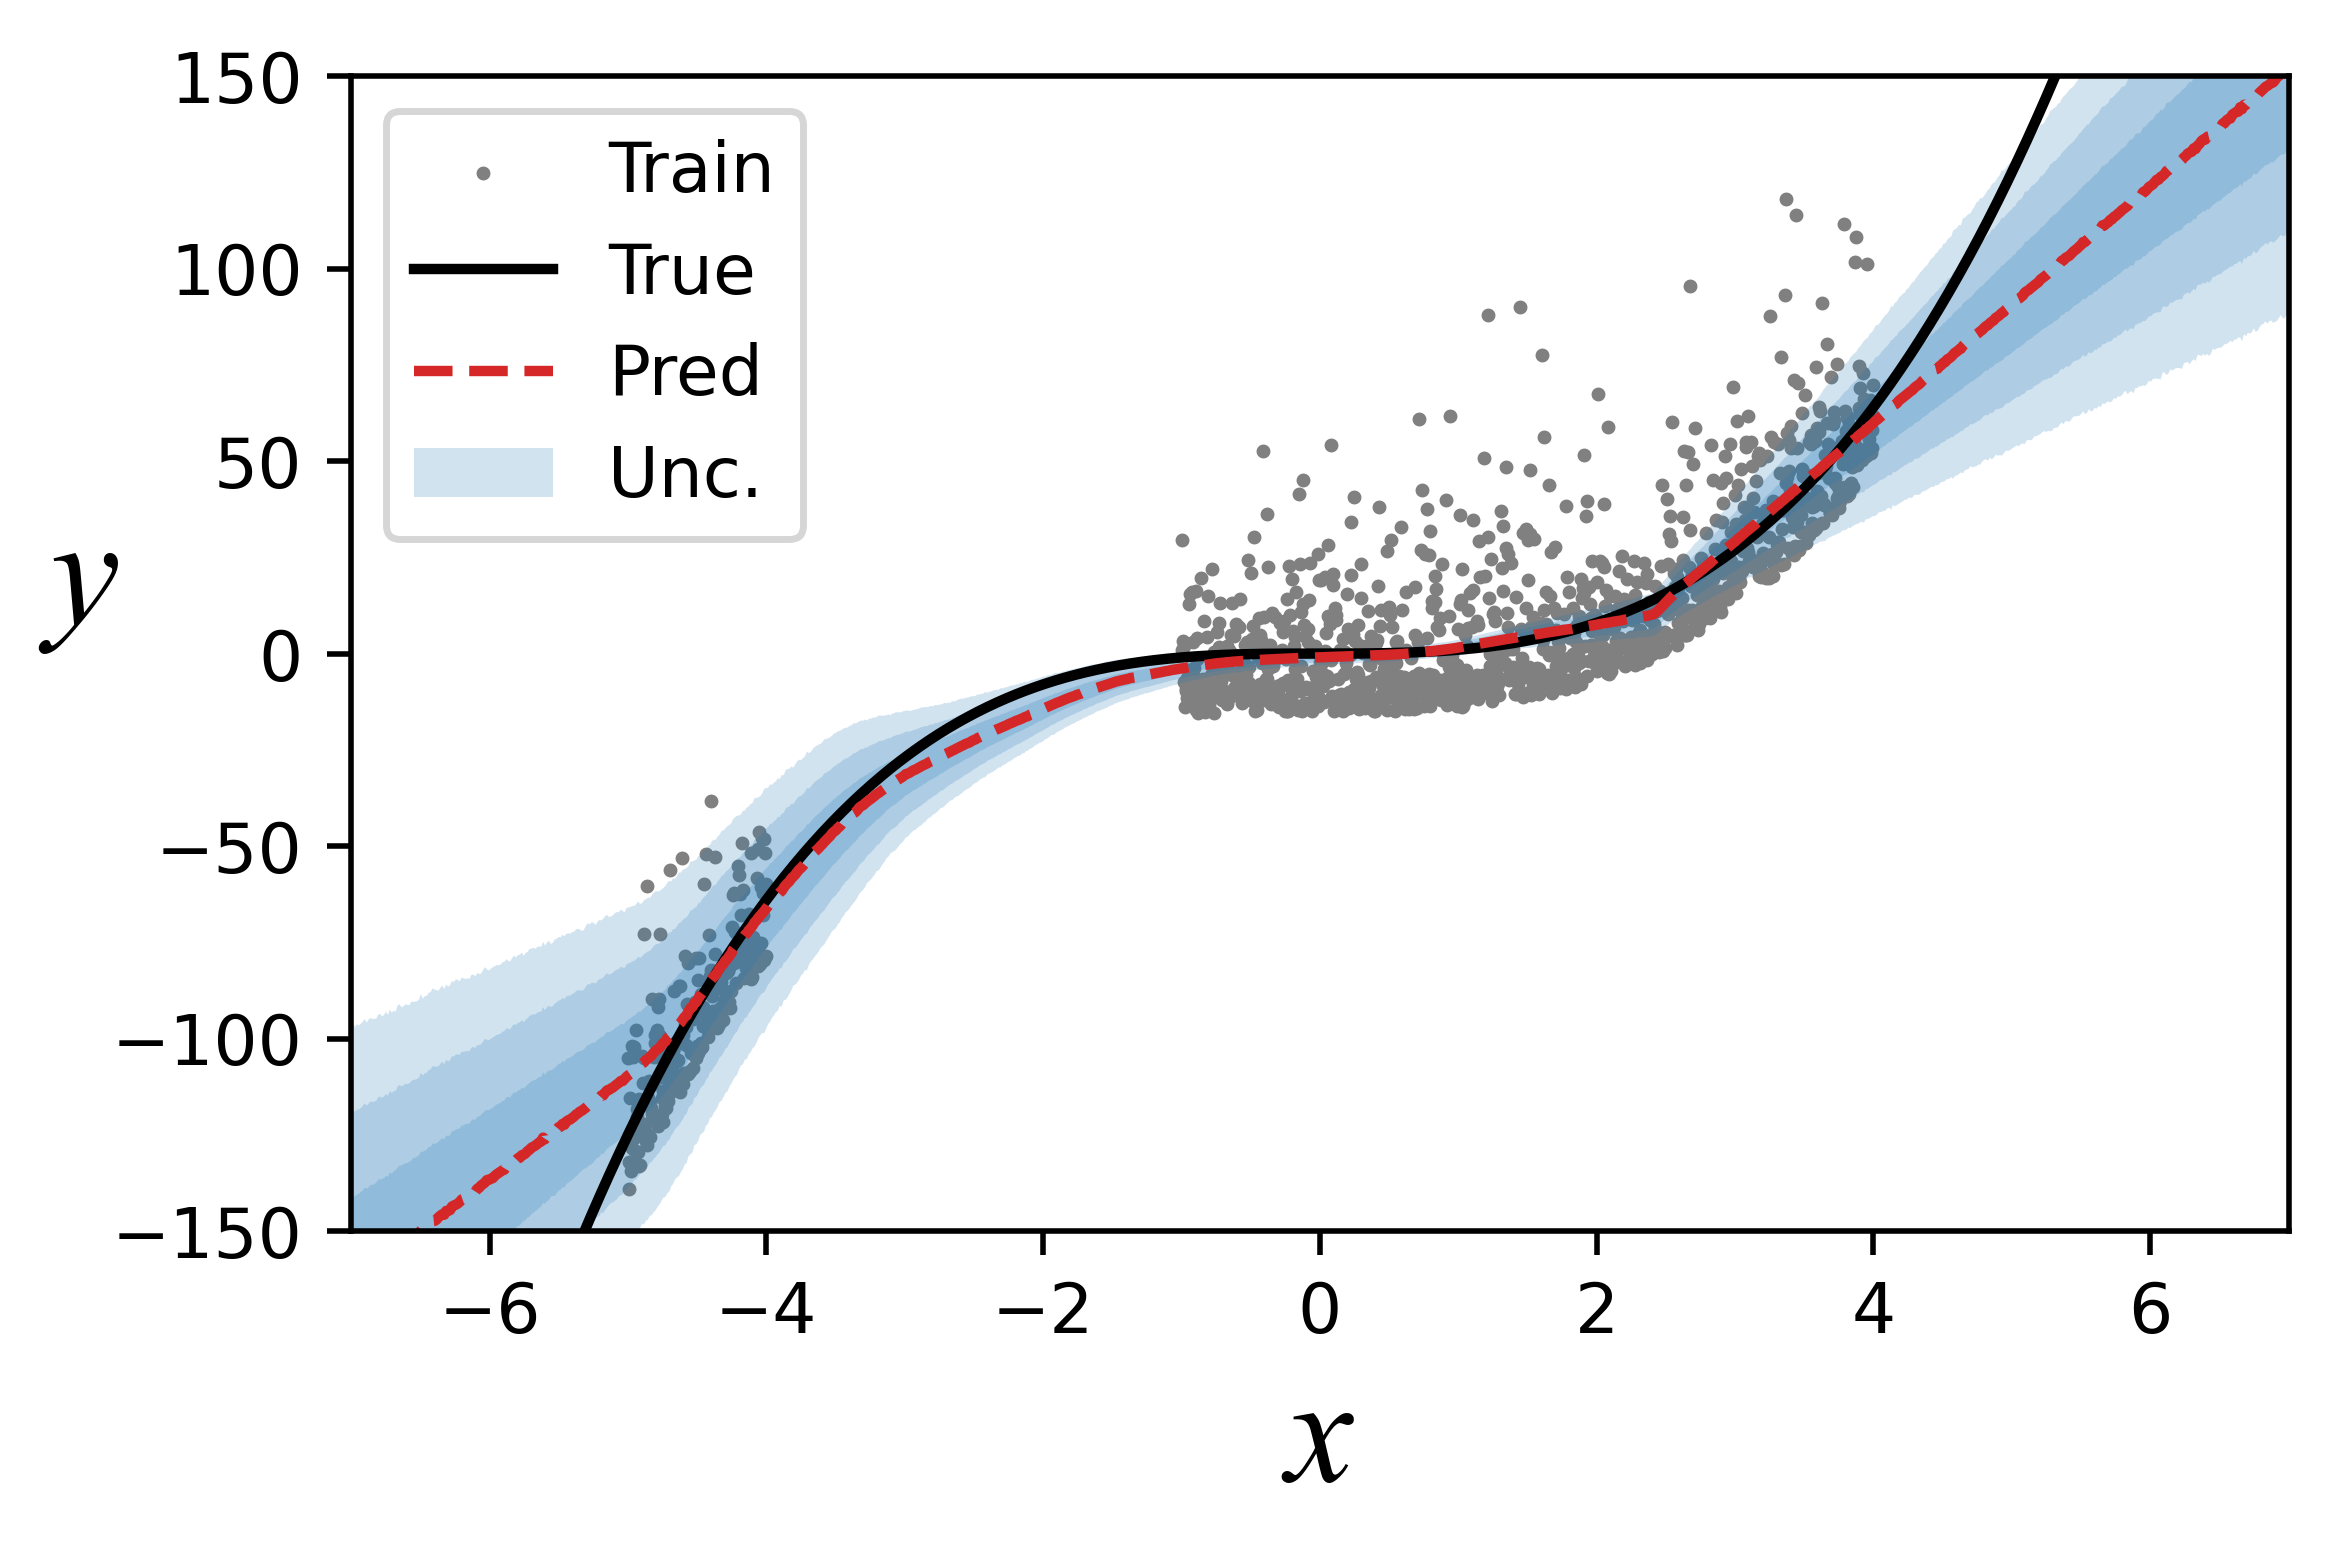

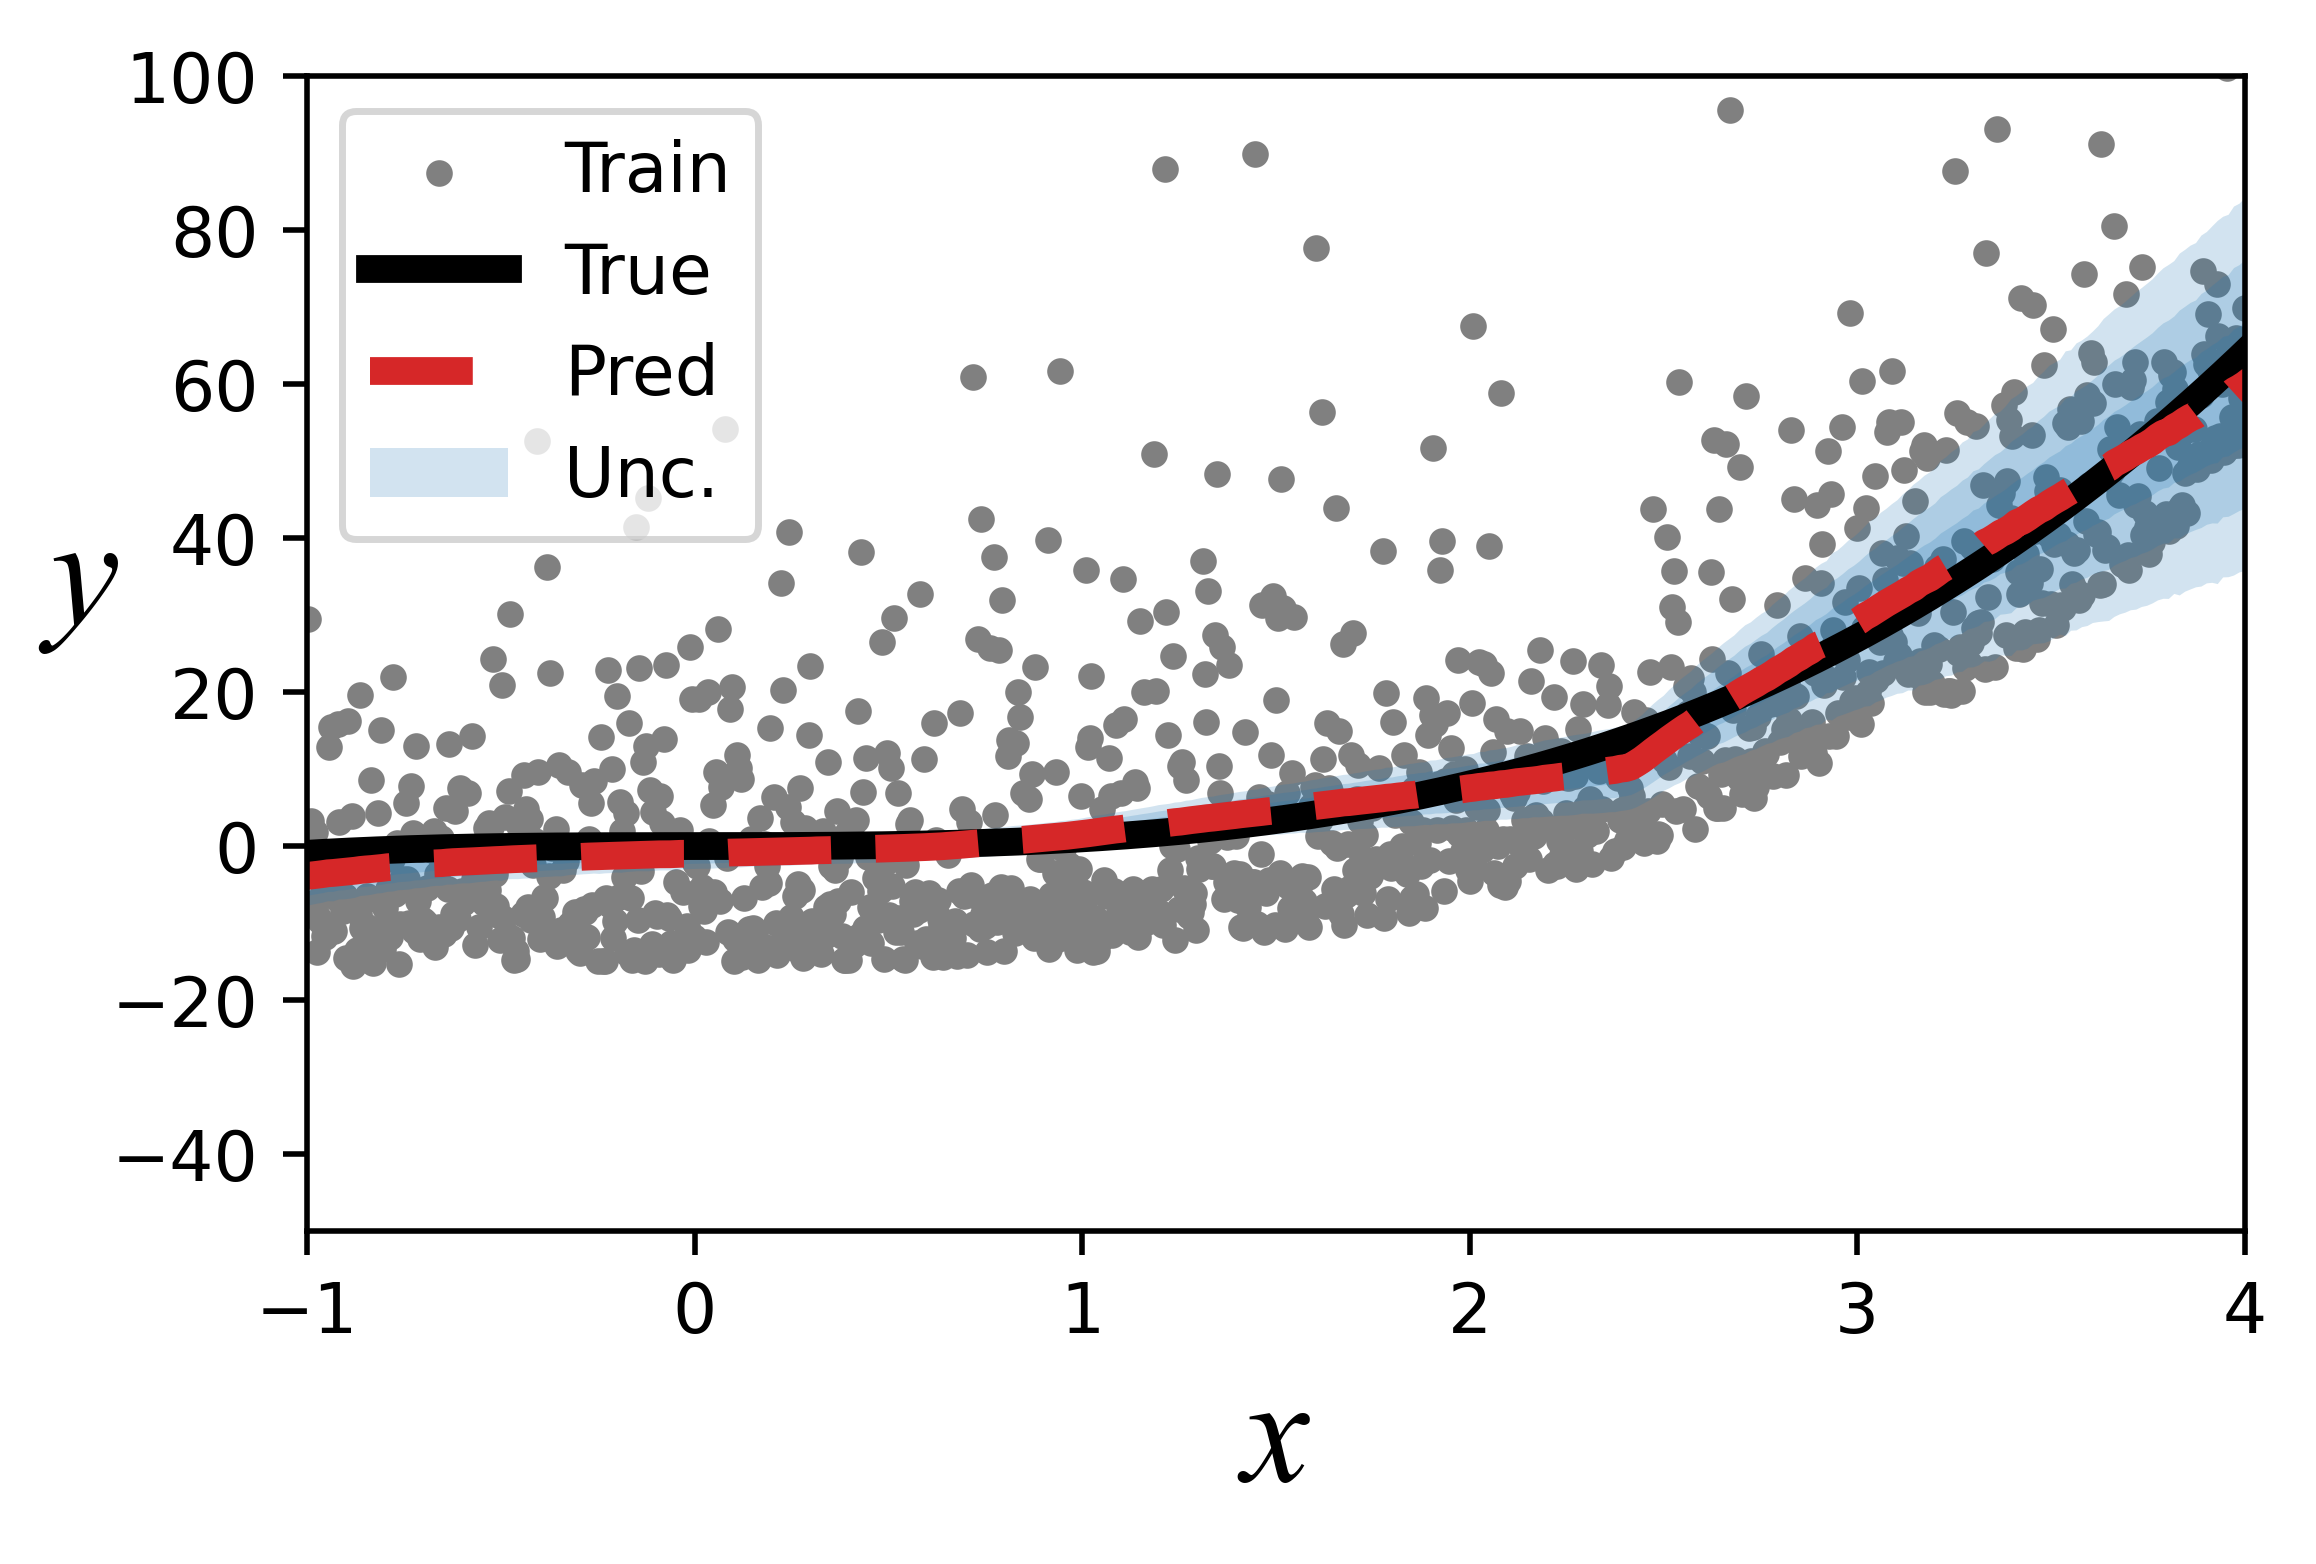

In [81]:

# Plot the results
plt.figure(figsize=(5, 3), dpi=500)
plt.scatter(x_train.cpu(), y_train.cpu(), s=1.0, c="gray", label="Train")
plt.plot(x_test.squeeze().cpu(), y_test.squeeze(), c="k", label="True")
plt.plot(x_test.squeeze().cpu(), mean_prediction, c="tab:red", ls="--", label="Pred")
for std in range(1, 4):  # Plot uncertainty bands (1 to 3 standard deviations)
    plt.fill_between(
        x_test.squeeze(),
        mean_prediction - std * uncertainty,
        mean_prediction + std * uncertainty,
        alpha=0.2,
        facecolor="tab:blue",
        label="Unc." if std == 1 else None,
    )
plt.gca().set_ylim(-150, 150)
plt.gca().set_xlim(-7, 7)
plt.legend(loc="upper left")

plt.xlabel("x", fontsize=22, fontdict={
    'family': 'Times New Roman',
    'style': 'italic'
})

plt.ylabel("y", fontsize=22, fontdict={
    'family': 'Times New Roman',
    'style': 'italic'
},rotation=0)
plt.legend(loc="upper left")

# ================================


# Plot the results
plt.figure(figsize=(5, 3), dpi=500)
plt.scatter(x_train.cpu(), y_train.cpu(), s=8.0, c="gray", label="Train", alpha=1, edgecolors=None)
plt.plot(x_test.squeeze().cpu(), y_test.squeeze(), c="k", label="True", linewidth=4)
plt.plot(x_test.squeeze().cpu(), mean_prediction, c="tab:red", ls="--", label="Pred", linewidth=4)
for std in range(1, 4):  # Plot uncertainty bands (1 to 3 standard deviations)
    plt.fill_between(
        x_test.squeeze(),
        mean_prediction - std * uncertainty,
        mean_prediction + std * uncertainty,
        alpha=0.2,
        facecolor="tab:blue",
        label="Unc." if std == 1 else None,
    )
plt.xlabel("x", fontsize=22, fontdict={
    'family': 'Times New Roman',
    'style': 'italic'
})

plt.ylabel("y", fontsize=22, fontdict={
    'family': 'Times New Roman',
    'style': 'italic'
},rotation=0)
plt.legend(loc="upper left")
plt.gca().set_ylim(-50, 100)
plt.gca().set_xlim(-1, 4)



In [ ]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Assumes these are torch tensors on CPU:
# mu, var, y_test, x_train, y_train
mu = mean_prediction
var = uncertainty

# If needed, convert to numpy
mu_np = mu.detach().cpu().numpy()
var_np = var.detach().cpu().numpy()
y_test_np = y_test.detach().cpu().numpy()

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test_np, mu_np))
print(f"RMSE: {rmse:.4f}")

# Compute R² score
r2 = r2_score(y_test_np, mu_np)
print(f"R^2: {r2:.4f}")

X_test_np = X_test if isinstance(X_test, np.ndarray) else X_test.detach().cpu().numpy()


# Check how many training targets fall within n std of predicted mean
coverage = {}
for n in range(1, 4):
    lower = mu_np - n * std
    upper = mu_np + n * std
    covered = (y_test_noisy >= lower) & (y_test_noisy <= upper)
    frac_covered = np.sum(covered) / len(y_test_noisy)
    coverage[n] = frac_covered
    print(f"Coverage within ±{n}σ: {frac_covered:.2%}")


RMSE: 56.2704
R^2: 0.8127
Coverage within ±1σ: 10.00%
Coverage within ±2σ: 20.80%
Coverage within ±3σ: 36.40%


# Ensemble

In [83]:
class EnsembleModel(nn.Module):
    def __init__(self):
        super(EnsembleModel, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Number of models in the ensemble
num_models = 10

# Initialize the ensemble of models, optimizers, and loss function
ensemble_models = [EnsembleModel().to(device) for _ in range(num_models)]
optimizers = [torch.optim.Adam(model.parameters(), lr=1e-3) for model in ensemble_models]
loss_fn = nn.MSELoss()

# Train each model in the ensemble
for model, optimizer in zip(ensemble_models, optimizers):
    model.train()
    for epoch in tqdm(range(500)):
        for x, y in DataLoader(TensorDataset(x_train, y_train), batch_size=100, shuffle=True):
            pred = model(x)
            loss = loss_fn(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# Perform inference with the ensemble
predictions = torch.zeros((num_models, x_test.size(0)))

with torch.no_grad():
    for i, model in enumerate(ensemble_models):
        predictions[i] = model(x_test.to(device)).squeeze()

# Calculate mean and uncertainty (standard deviation)
mean_prediction = predictions.mean(dim=0).cpu()
uncertainty = predictions.std(dim=0).cpu()


100%|██████████| 500/500 [00:07<00:00, 65.01it/s]


(-1.0, 4.0)

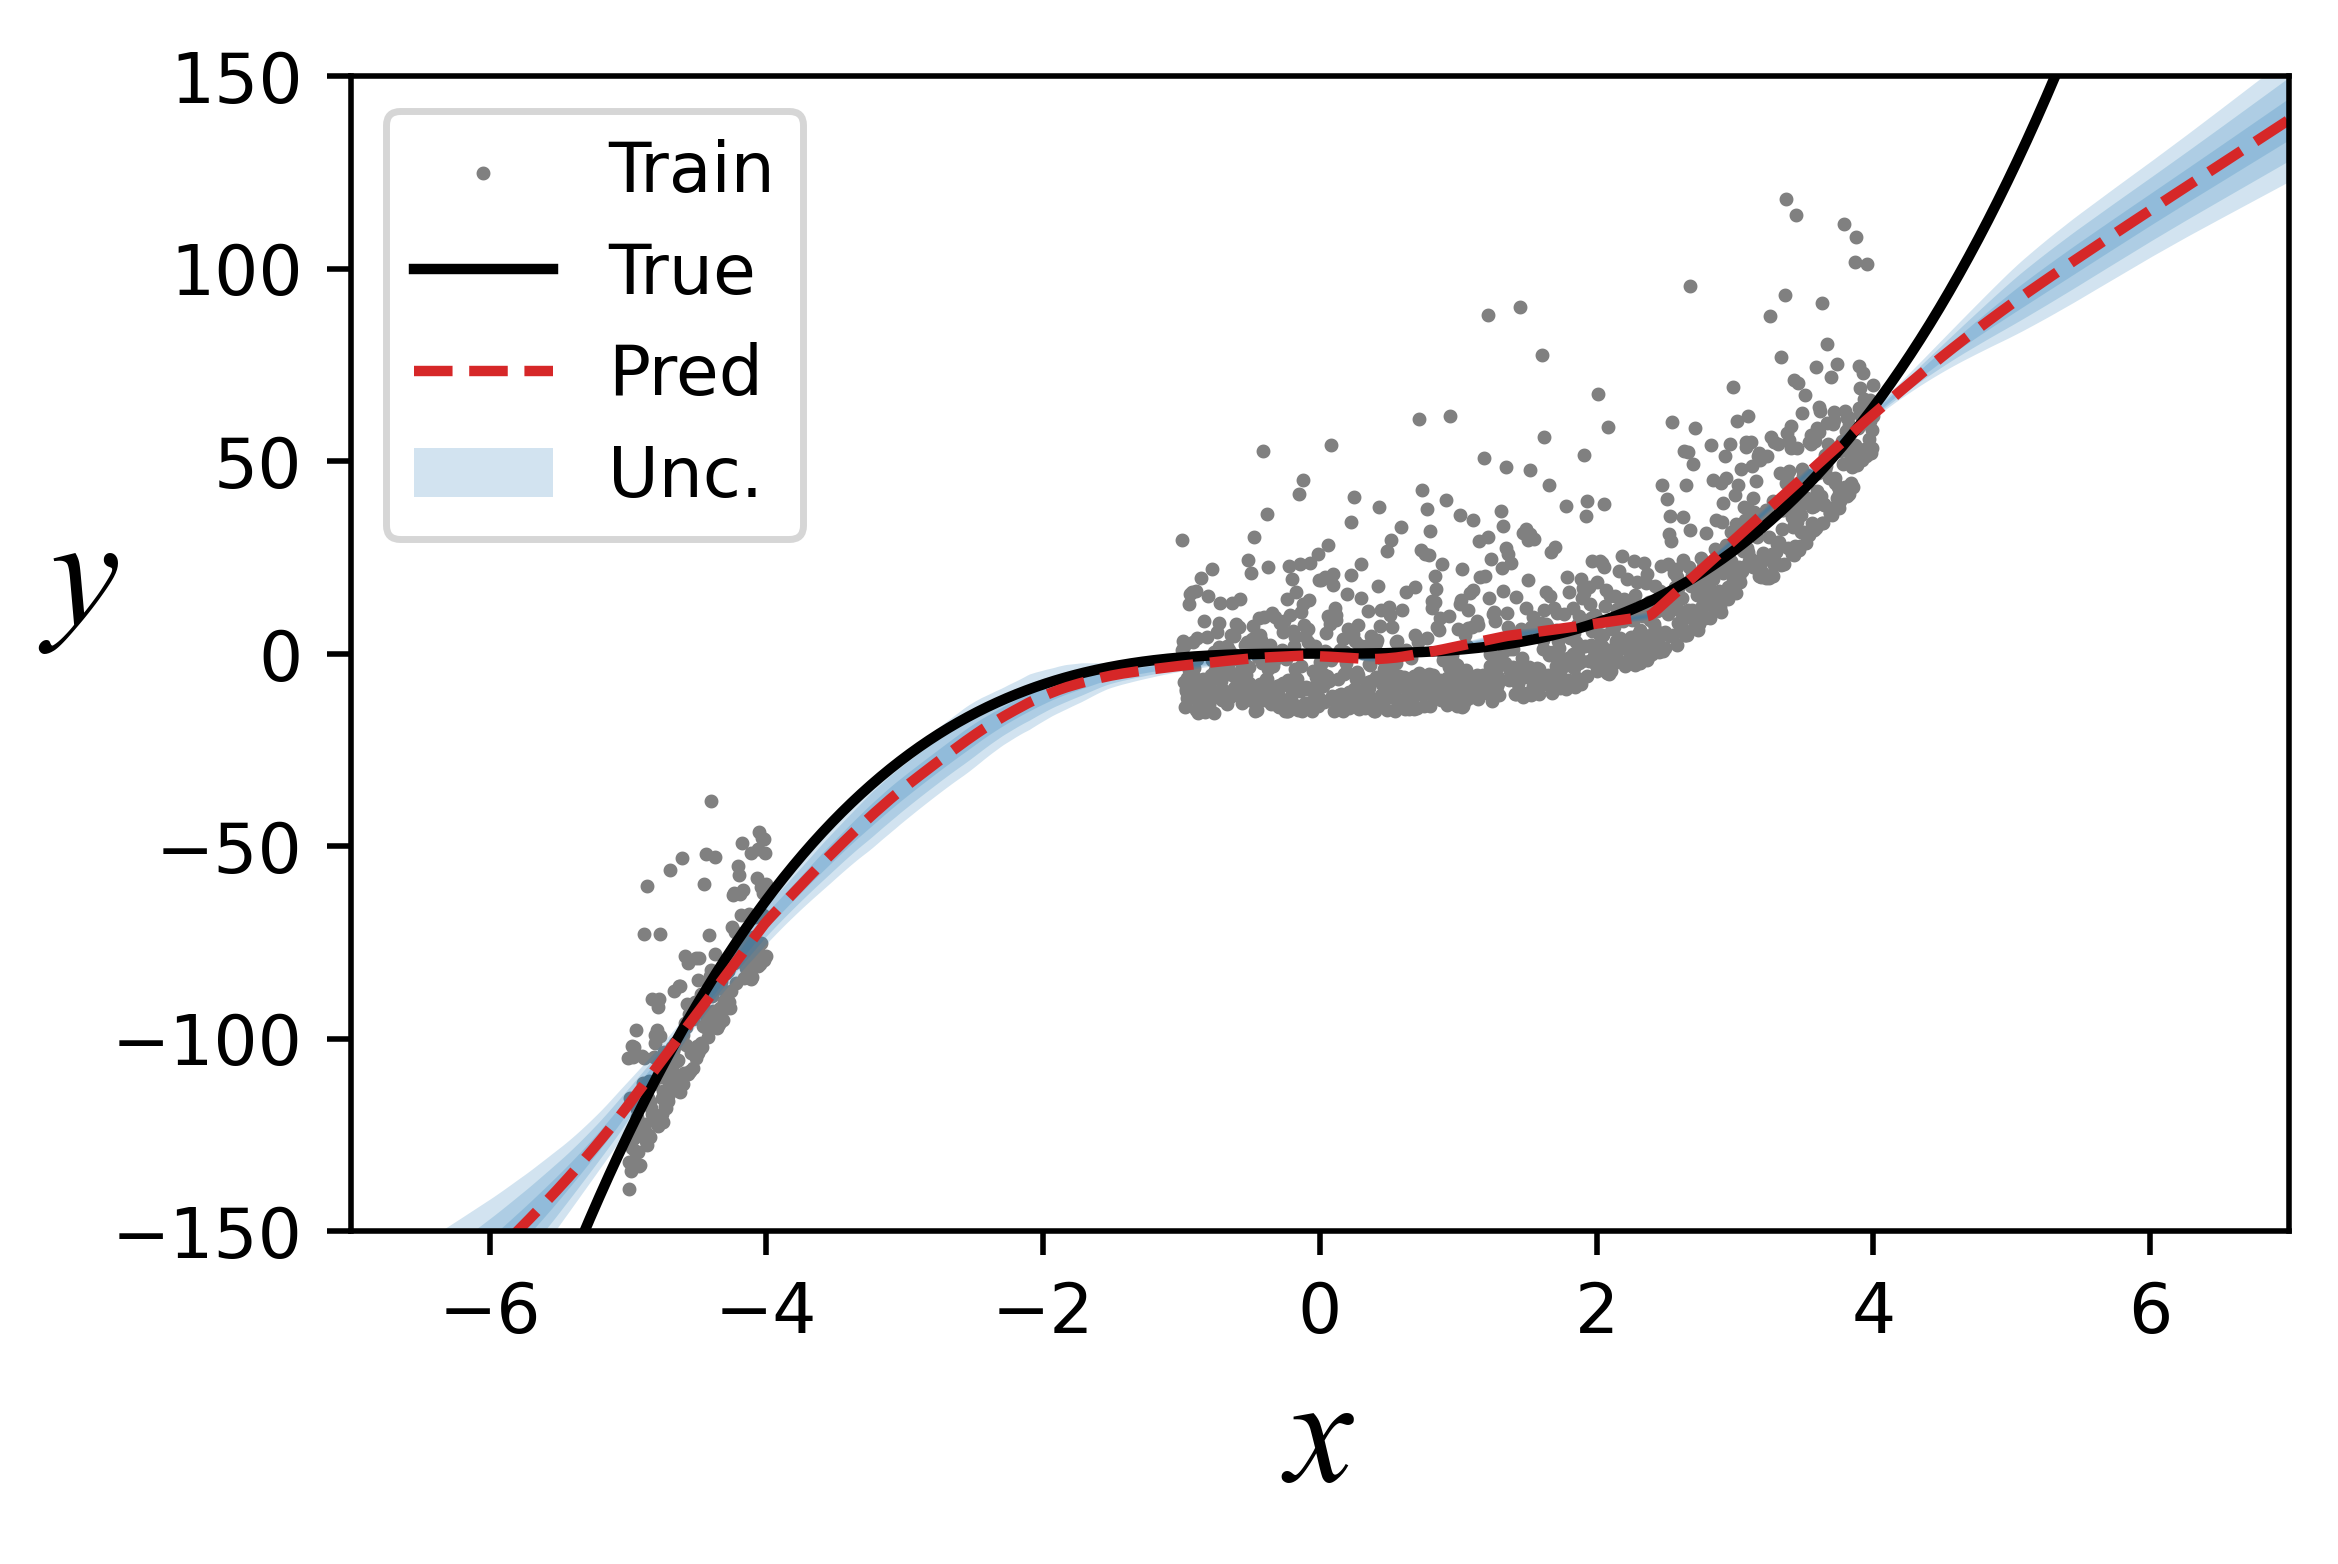

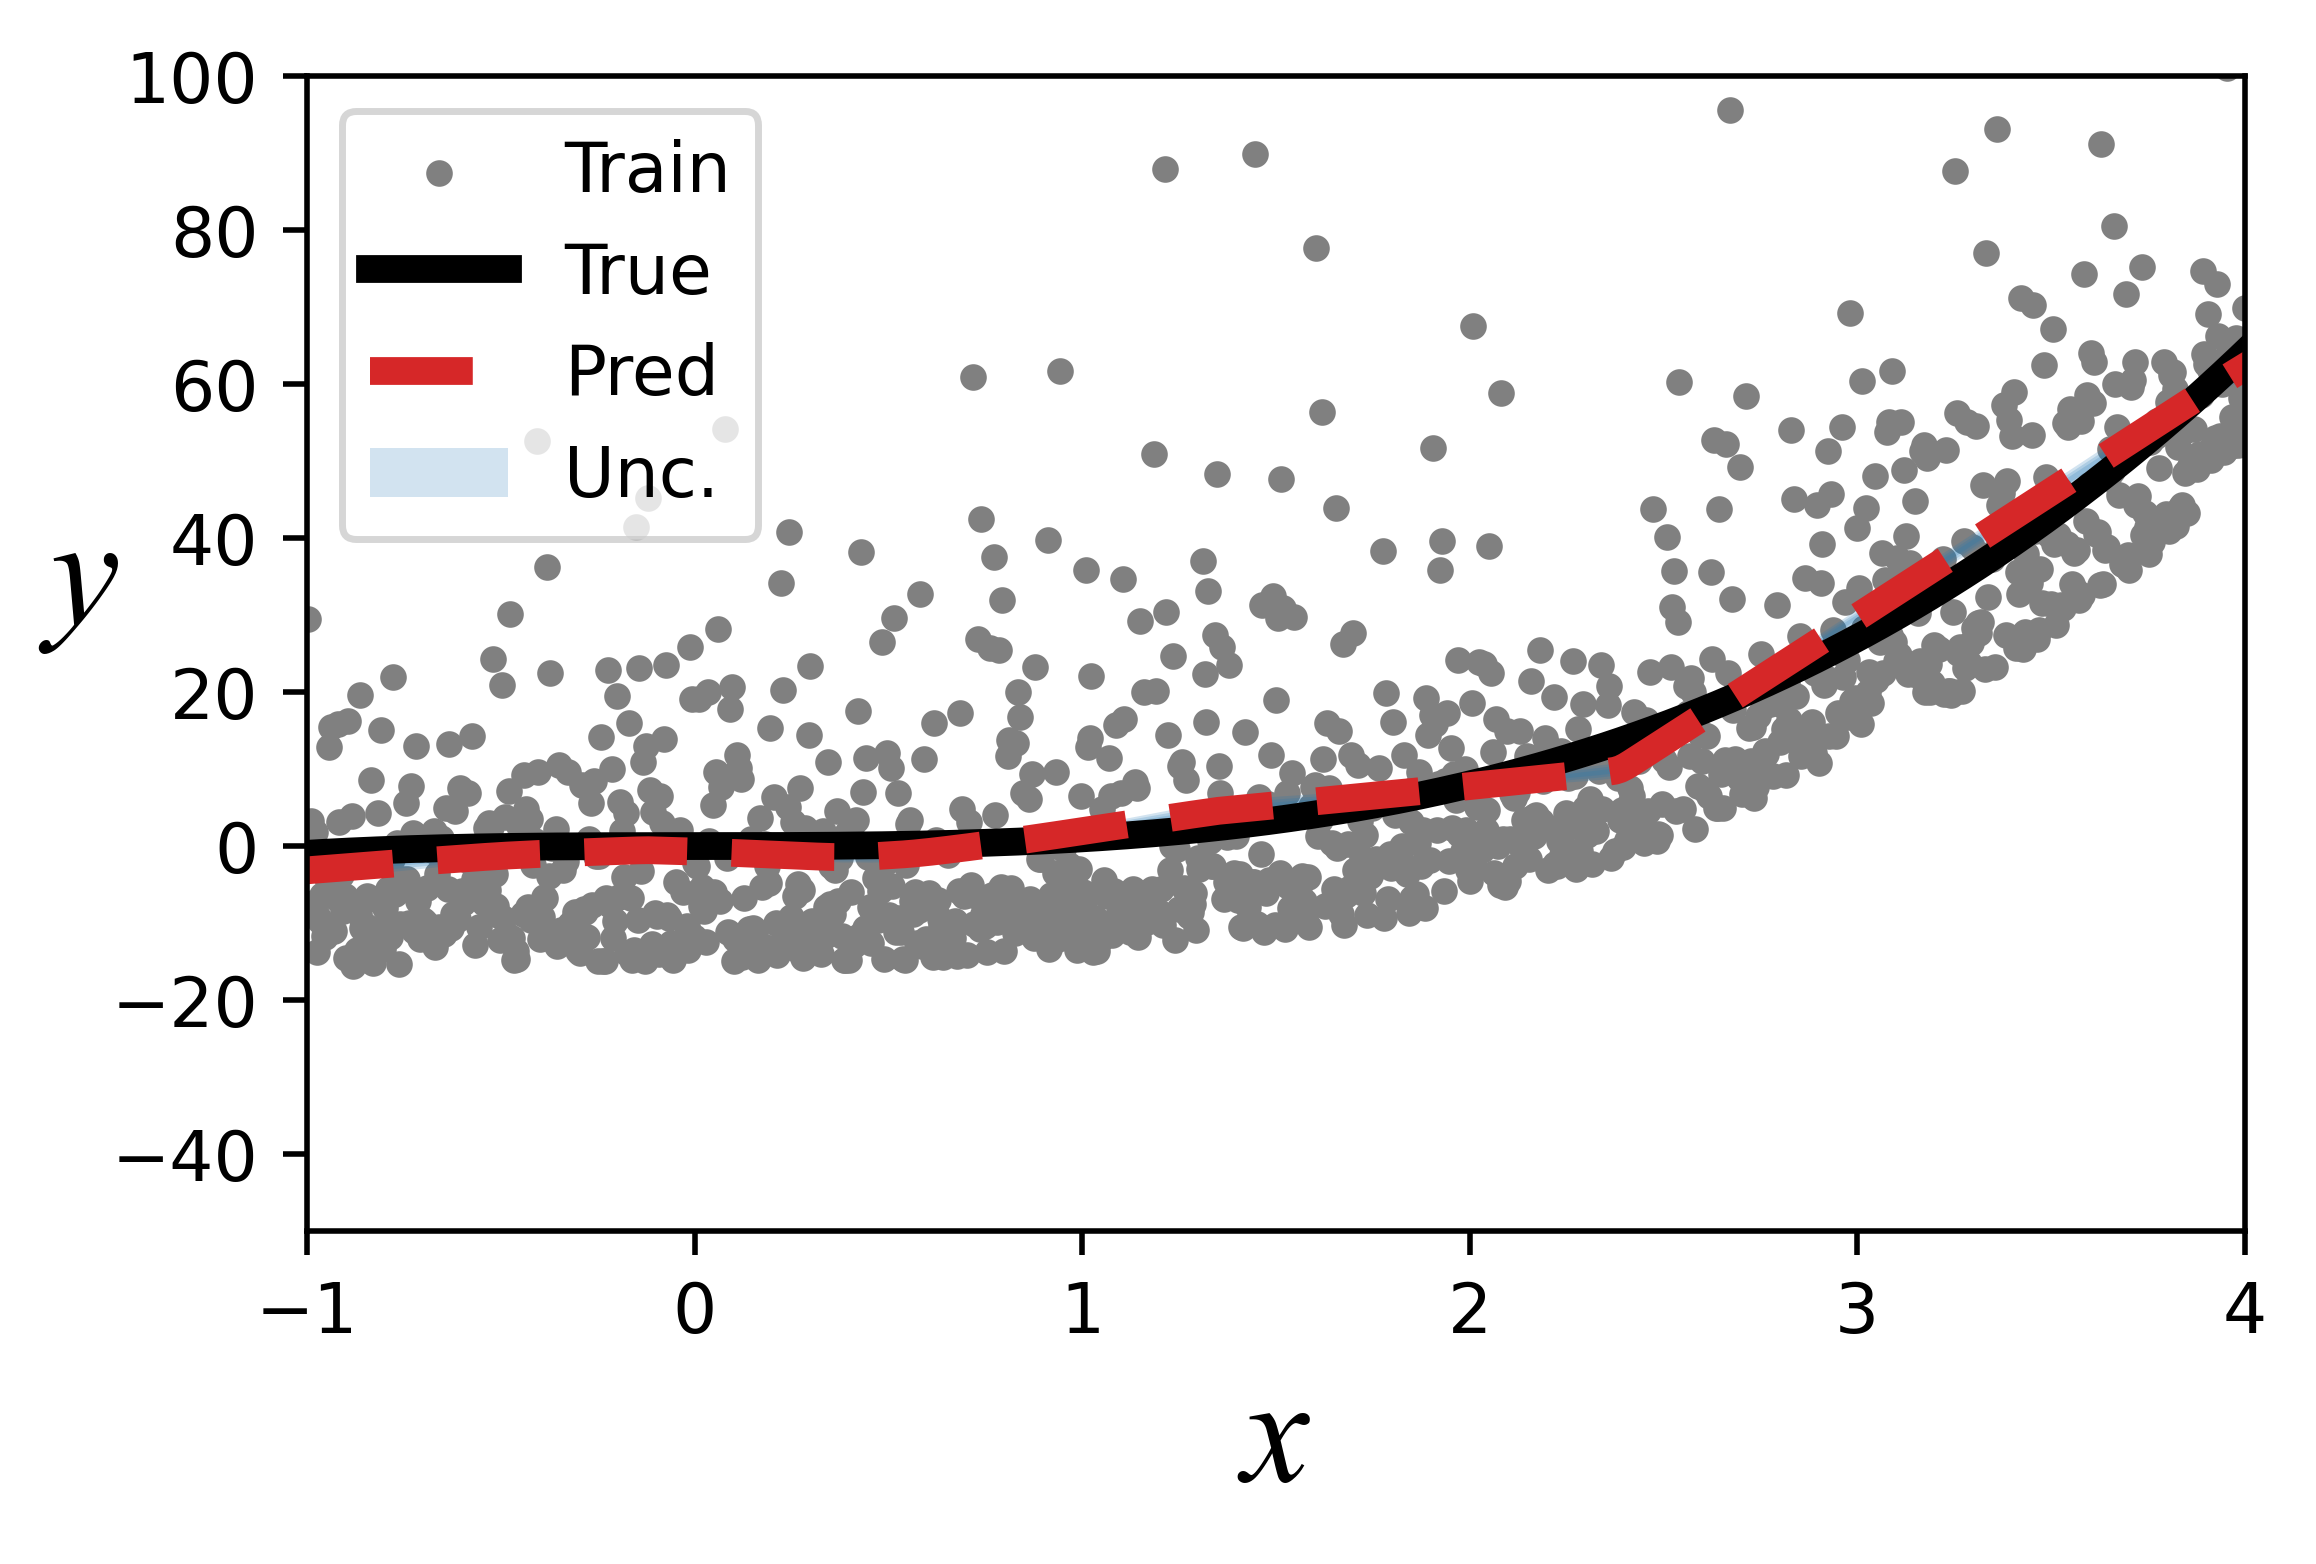

In [84]:

# Plot the results
plt.figure(figsize=(5, 3), dpi=500)
plt.scatter(x_train.cpu(), y_train.cpu(), s=1.0, c="gray", label="Train")
plt.plot(x_test.squeeze().cpu(), y_test.squeeze(), c="k", label="True")
plt.plot(x_test.squeeze().cpu(), mean_prediction, c="tab:red", ls="--", label="Pred")
for std in range(1, 4):  # Plot uncertainty bands (1 to 3 standard deviations)
    plt.fill_between(
        x_test.squeeze(),
        mean_prediction - std * uncertainty,
        mean_prediction + std * uncertainty,
        alpha=0.2,
        facecolor="tab:blue",
        label="Unc." if std == 1 else None,
    )
plt.gca().set_ylim(-150, 150)
plt.gca().set_xlim(-7, 7)
plt.legend(loc="upper left")

plt.xlabel("x", fontsize=22, fontdict={
    'family': 'Times New Roman',
    'style': 'italic'
})

plt.ylabel("y", fontsize=22, fontdict={
    'family': 'Times New Roman',
    'style': 'italic'
},rotation=0)
plt.legend(loc="upper left")

# ================================


# Plot the results
plt.figure(figsize=(5, 3), dpi=500)
plt.scatter(x_train.cpu(), y_train.cpu(), s=8.0, c="gray", label="Train", alpha=1, edgecolors=None)
plt.plot(x_test.squeeze().cpu(), y_test.squeeze(), c="k", label="True", linewidth=4)
plt.plot(x_test.squeeze().cpu(), mean_prediction, c="tab:red", ls="--", label="Pred", linewidth=4)
for std in range(1, 4):  # Plot uncertainty bands (1 to 3 standard deviations)
    plt.fill_between(
        x_test.squeeze(),
        mean_prediction - std * uncertainty,
        mean_prediction + std * uncertainty,
        alpha=0.2,
        facecolor="tab:blue",
        label="Unc." if std == 1 else None,
    )
plt.xlabel("x", fontsize=22, fontdict={
    'family': 'Times New Roman',
    'style': 'italic'
})

plt.ylabel("y", fontsize=22, fontdict={
    'family': 'Times New Roman',
    'style': 'italic'
},rotation=0)
plt.legend(loc="upper left")
plt.gca().set_ylim(-50, 100)
plt.gca().set_xlim(-1, 4)

In [ ]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Assumes these are torch tensors on CPU:
# mu, var, y_test, x_train, y_train
mu = mean_prediction
var = uncertainty

# If needed, convert to numpy
mu_np = mu.detach().cpu().numpy()
var_np = var.detach().cpu().numpy()
y_test_np = y_test.detach().cpu().numpy()

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test_np, mu_np))
print(f"RMSE: {rmse:.4f}")

# Compute R² score
r2 = r2_score(y_test_np, mu_np)
print(f"R^2: {r2:.4f}")

X_test_np = X_test if isinstance(X_test, np.ndarray) else X_test.detach().cpu().numpy()


# Check how many training targets fall within n std of predicted mean
coverage = {}
for n in range(1, 4):
    lower = mu_np - n * std
    upper = mu_np + n * std
    covered = (y_test_noisy >= lower) & (y_test_noisy <= upper)
    frac_covered = np.sum(covered) / len(y_test_noisy)
    coverage[n] = frac_covered
    print(f"Coverage within ±{n}σ: {frac_covered:.2%}")


RMSE: 53.9461
R^2: 0.8279
Coverage within ±1σ: 11.10%
Coverage within ±2σ: 23.30%
Coverage within ±3σ: 36.30%


# Quantile Regression

In [12]:
# Define the Quantile Regression Model
class QuantileRegressionModel(nn.Module):
    def __init__(self):
        super(QuantileRegressionModel, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the quantile loss function
def quantile_loss(pred, target, quantile):
    error = target - pred
    return torch.mean(torch.max((quantile - 1) * error, quantile * error))

# Add additional quantiles
quantiles = [0.001, 0.05, 0.25, 0.5, 0.75, 0.95, 0.999]

# Initialize models for each quantile
models = {q: QuantileRegressionModel().to(device) for q in quantiles}
optimizers = {q: torch.optim.Adam(models[q].parameters(), lr=1e-3) for q in quantiles}

# Train each model
for quantile in (quantiles):
    model = models[quantile]
    optimizer = optimizers[quantile]
    model.train()
    for epoch in tqdm(range(500)):
        for x, y in DataLoader(TensorDataset(x_train, y_train), batch_size=100, shuffle=True):
            pred = model(x)
            loss = quantile_loss(pred, y, quantile)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


100%|██████████| 500/500 [00:08<00:00, 57.32it/s]


In [13]:

# Make predictions for each quantile
predictions = {}
with torch.no_grad():
    for quantile in quantiles:
        predictions[quantile] = models[quantile](x_test.to(device)).squeeze()


# Extract predictions
lower_bound_99 = predictions[0.001].cpu()
lower_bound_95 = predictions[0.05].cpu()
lower_bound_75 = predictions[0.25].cpu()
median = predictions[0.5].cpu()
upper_bound_75 = predictions[0.75].cpu()
upper_bound_95 = predictions[0.95].cpu()
upper_bound_99 = predictions[0.999].cpu()


(-1.0, 4.0)

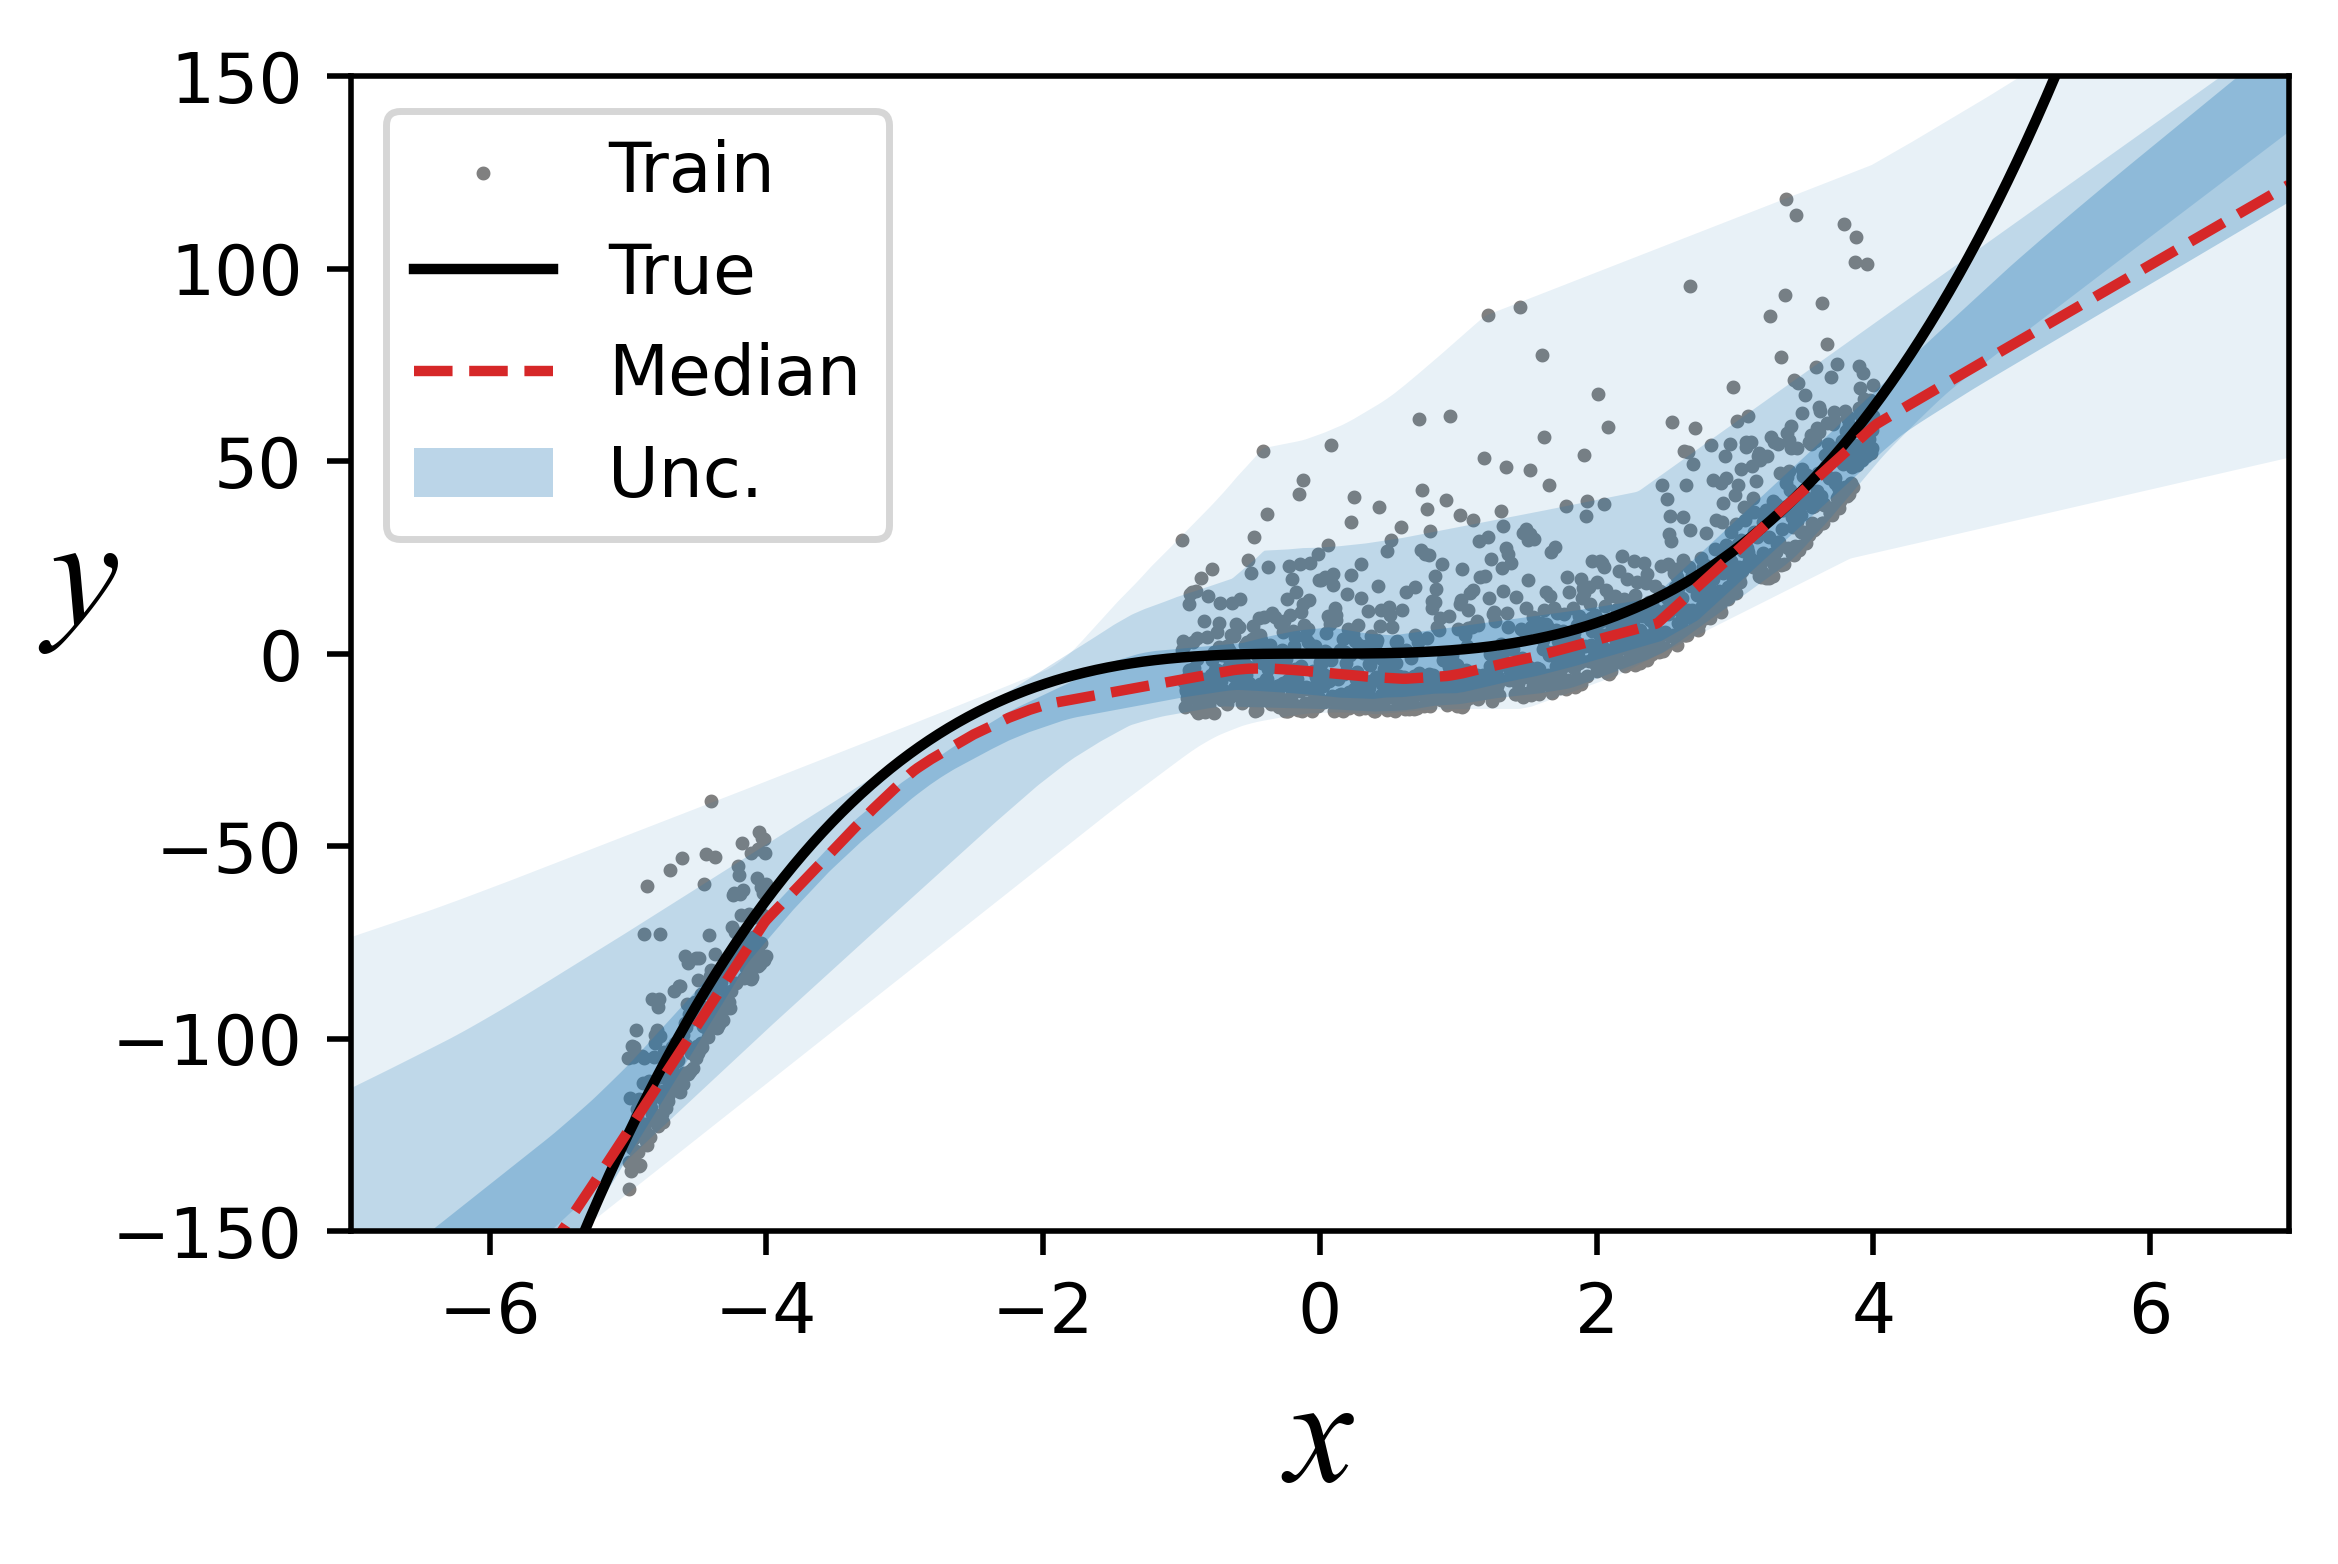

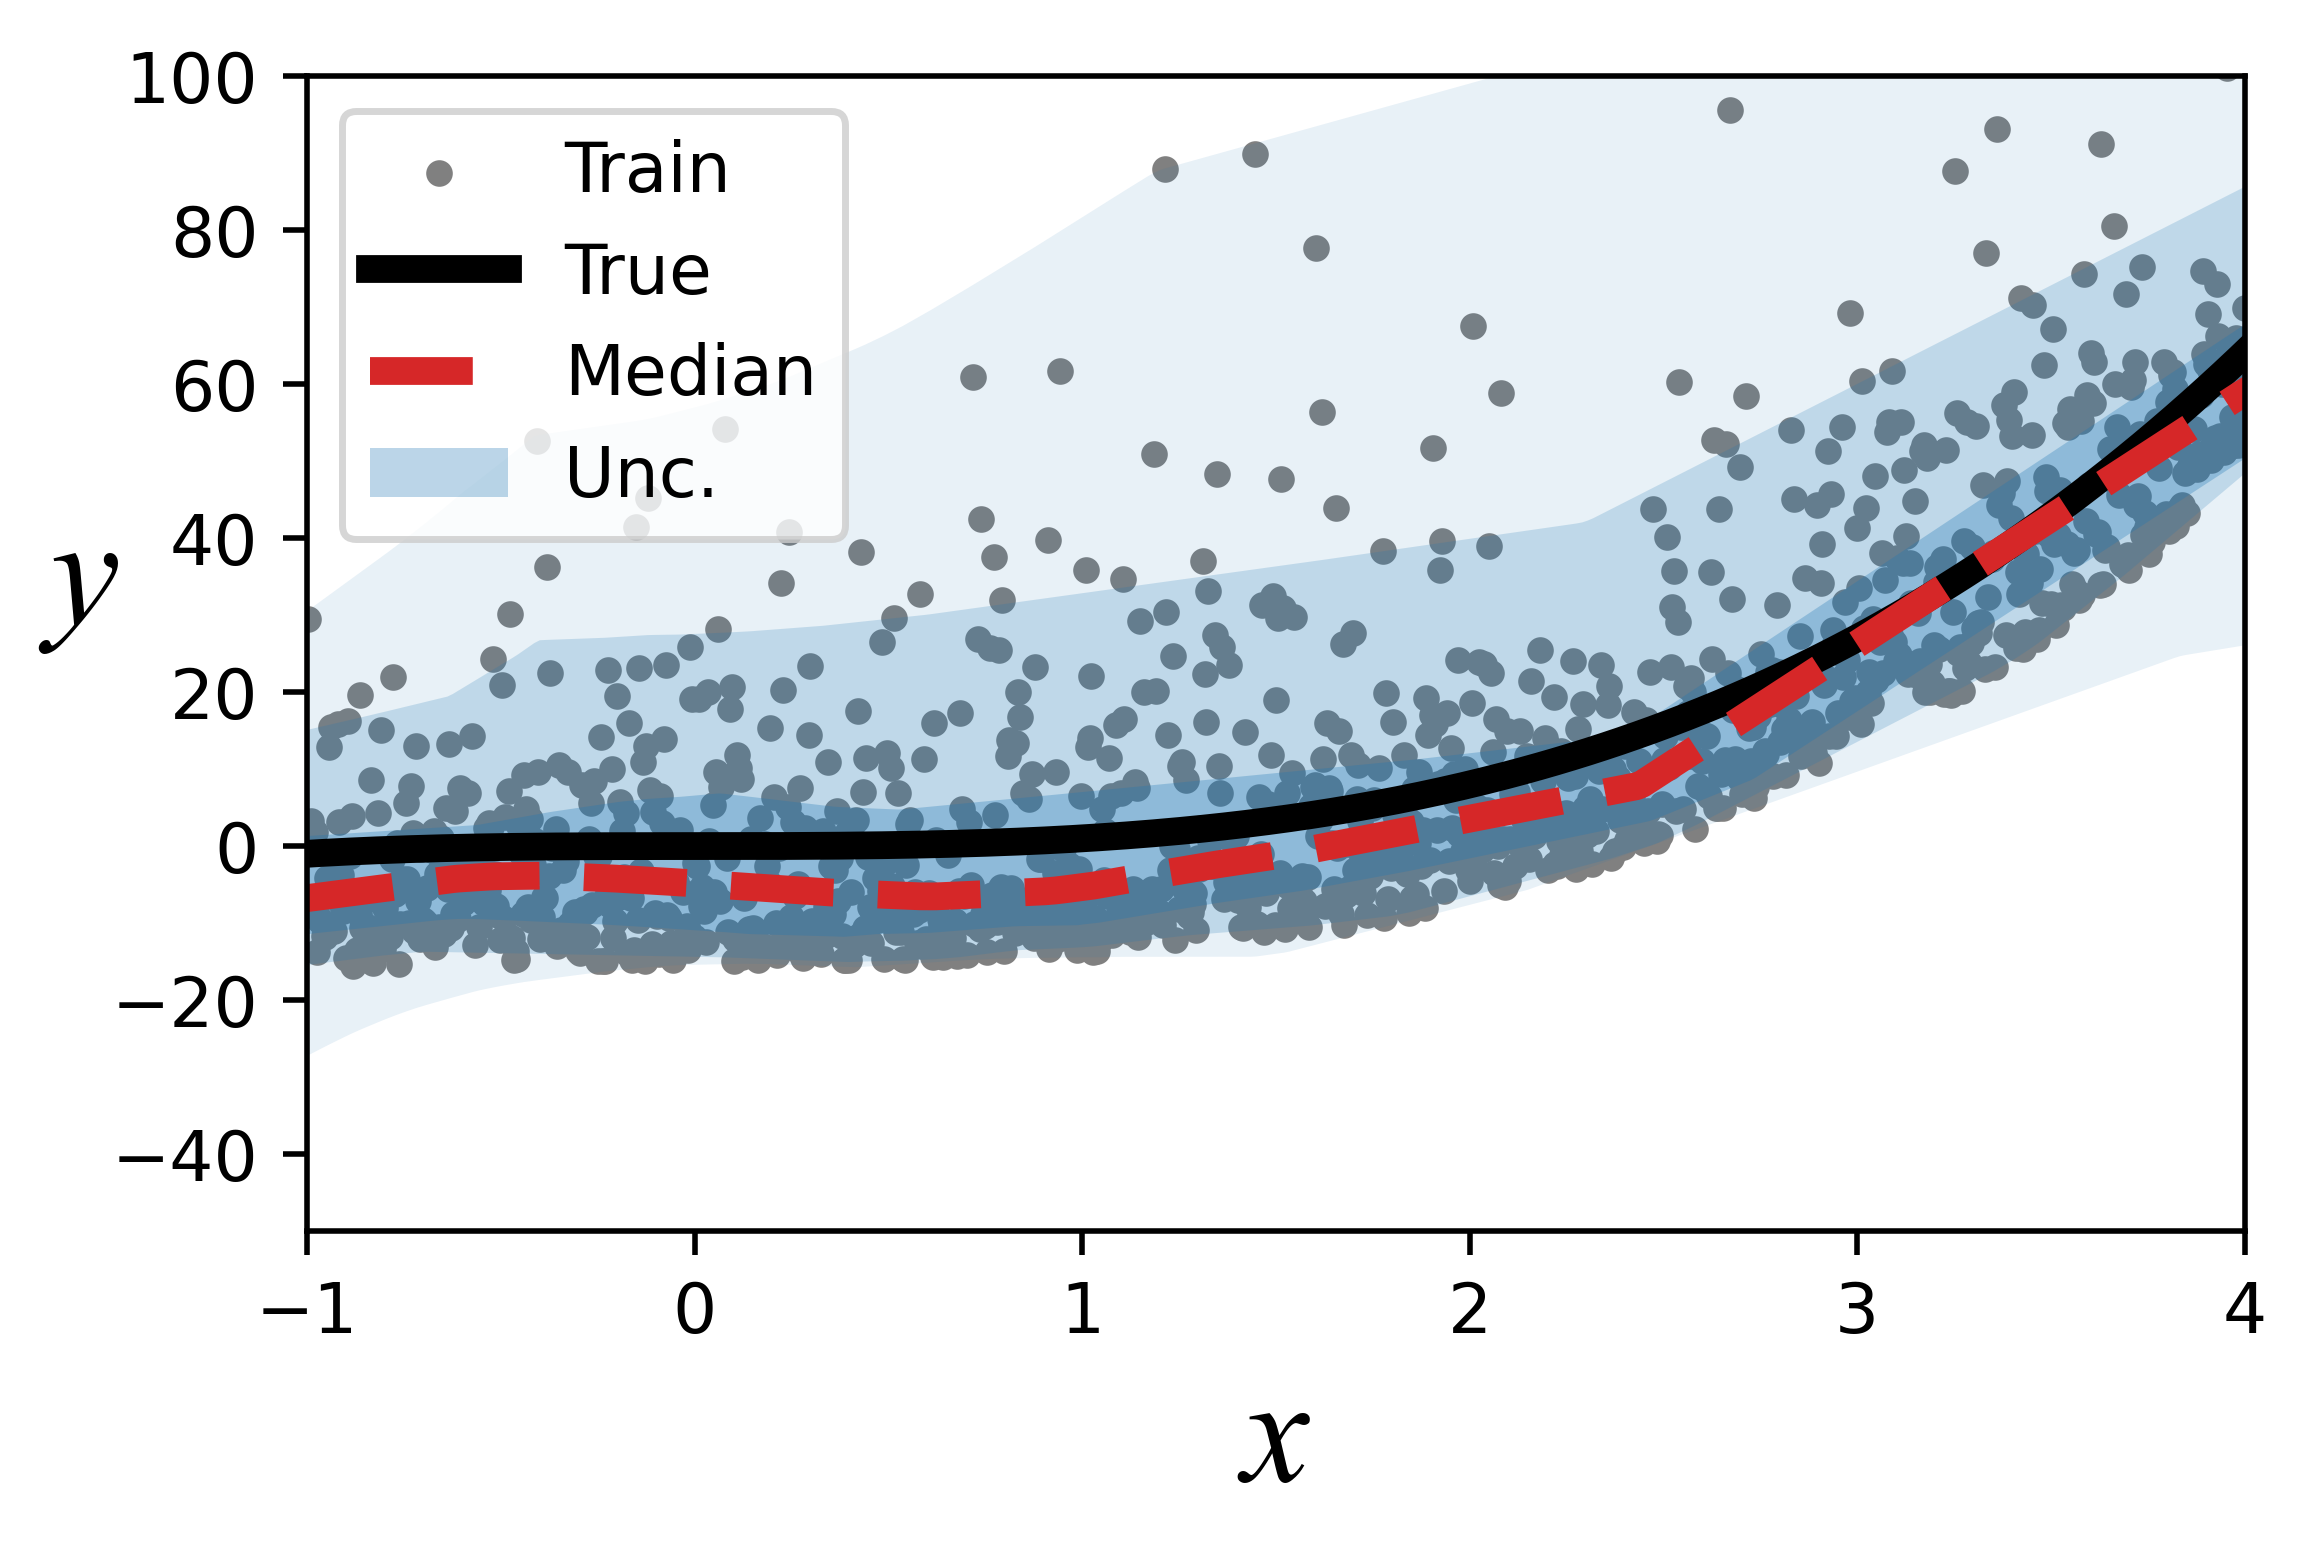

In [14]:

# Plot the results
plt.figure(figsize=(5, 3), dpi=500)
plt.scatter(x_train.cpu(), y_train.cpu(), s=1.0, c="gray", label="Train")
plt.plot(x_test.squeeze(), y_test.squeeze(), c="k", label="True")
plt.plot(x_test.squeeze(), median, c="tab:red", ls="--", label="Median")

# Fill between quantiles with different shades of blue
plt.fill_between(
    x_test.squeeze(),
    lower_bound_99,
    upper_bound_99,
    alpha=0.1,
    facecolor="tab:blue",
)
plt.fill_between(
    x_test.squeeze(),
    lower_bound_95,
    upper_bound_95,
    alpha=0.2,
    facecolor="tab:blue",
)
plt.fill_between(
    x_test.squeeze(),
    lower_bound_75,
    upper_bound_75,
    alpha=0.3,
    facecolor="tab:blue",
    label="Unc.",
)

plt.gca().set_ylim(-150, 150)
plt.gca().set_xlim(-7, 7)

plt.xlabel("x", fontsize=22, fontdict={
    'family': 'Times New Roman',
    'style': 'italic'
})

plt.ylabel("y", fontsize=22, fontdict={
    'family': 'Times New Roman',
    'style': 'italic'
},rotation=0)
plt.legend(loc="upper left")


# ================================


# Plot the results
plt.figure(figsize=(5, 3), dpi=500)
plt.scatter(x_train.cpu(), y_train.cpu(), s=8.0, c="gray", label="Train", alpha=1, edgecolors=None)
plt.plot(x_test.squeeze(), y_test.squeeze(), c="k", label="True", linewidth=4)
plt.plot(x_test.squeeze(), median, c="tab:red", ls="--", label="Median", linewidth=4)

# Fill between quantiles with different shades of blue
plt.fill_between(
    x_test.squeeze(),
    lower_bound_99,
    upper_bound_99,
    alpha=0.1,
    facecolor="tab:blue",
)
plt.fill_between(
    x_test.squeeze(),
    lower_bound_95,
    upper_bound_95,
    alpha=0.2,
    facecolor="tab:blue",
)
plt.fill_between(
    x_test.squeeze(),
    lower_bound_75,
    upper_bound_75,
    alpha=0.3,
    facecolor="tab:blue",
    label="Unc.",
)

plt.gca().set_ylim(-150, 150)
plt.gca().set_xlim(-7, 7)

plt.xlabel("x", fontsize=22, fontdict={
    'family': 'Times New Roman',
    'style': 'italic'
})

plt.ylabel("y", fontsize=22, fontdict={
    'family': 'Times New Roman',
    'style': 'italic'
},rotation=0)
plt.legend(loc="upper left")
plt.gca().set_ylim(-50, 100)
plt.gca().set_xlim(-1, 4)


In [ ]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Assumes these are torch tensors on CPU:
# mu, var, y_test, x_train, y_train
mu = median

# If needed, convert to numpy
mu_np = mu.detach().cpu().numpy()
y_test_np = y_test.detach().cpu().numpy()

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test_np, mu_np))
print(f"RMSE: {rmse:.4f}")

# Compute R² score
r2 = r2_score(y_test_np, mu_np)
print(f"R^2: {r2:.4f}")


coverage = {}
lower_list = [lower_bound_75, lower_bound_95, lower_bound_99]
upper_list = [upper_bound_75, upper_bound_95, upper_bound_99]
for n in range(1, 4):
    lower = lower_list[n-1].numpy()
    upper = upper_list[n-1].numpy()
    covered = (y_test_noisy >= lower) & (y_test_noisy <= upper)
    frac_covered = np.sum(covered) / len(y_test_noisy)
    coverage[n] = frac_covered
    print(f"Coverage within ±{n}σ: {frac_covered:.2%}")


RMSE: 54.8842
R^2: 0.8218
Coverage within ±1σ: 30.20%
Coverage within ±2σ: 59.20%
Coverage within ±3σ: 70.20%
